# in-vehicle coupon recommendation

### Problem description

The usage of discount coupons has become a fundamental aspect of marketing strategies. The goal is not only to drive sales but also to enhance the Customer Retention rate. The objective is to build a system that strikes a balance between predicting people behavior and optimizing marketing costs, ensuring that the offered discounts are directed towards people who are more likely to use them.

This data studies whether a person will accept the coupon recommended to them in different driving scenarios - it is a classification task.

### Dataset description

The data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios and then asks the person whether they will accept the coupon if they are the driver. The multivariate dataset includes 26 features and 12684 instances. There are also missing values. 

For more information about the dataset, please refer to the paper: Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

### Attribute information

#### Baseline data

- destination - where is he/she headed to

- passanger - who are the passengers in the car

- weather - what is the weather like

- temperature - the temperature given in Fahrenheit 

- time - what o'clock is it  

- coupon - the type of a coupon 

- expiration - the coupon expires in 1 day or in 2 hours 

- gender - male or female

- age - the age range

- maritalStatus - the marital status

- has_Children - does he/she have children 

- education - the education level

- occupation - which sector do they work in

- income - the annual income range

- Bar - the number of times that he/she goes to a bar every month 

- CoffeeHouse - the number of times that he/she goes to a coffee house every month 

- CarryAway - the number of times that he/she buys takeaway food every month 

- RestaurantLessThan20 - the number of times that he/she eats at a restaurant with average expense less than 20 dollars per person every month 

- Restaurant20To50 - the number of times that he/she goes to a restaurant with average expense per person of 20 - 50 dollars every month 

- toCoupon_GEQ15min - the driving distance to the restaurant/bar for using the coupon is greater than 15 minutes 

- toCoupon_GEQ25min -  the driving distance to the restaurant/bar for using the coupon is greater than 25 minutes 

- direction_same - whether the restaurant/bar is in the same direction as his/her current destination 

- direction_opp - whether the restaurant/bar is in the same direction as his/her current destination  

- Y - whether the coupon is accepted  

In [1]:
#load dependencies
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from itertools import product
from pathlib import Path
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

#set Pandas display option 
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 500)

#set figure size
plt.rcParams['figure.figsize'] = (8, 6)

#ensure that code is reproducible by setting random seed
np.random.seed(1916) 

In [2]:
#project setup
input_data_path = "../data/input"
output_data_path = "../data/output"

In [3]:
#load data
df = pd.read_csv(f"{input_data_path}/in-vehicle-coupon-recommendation.csv")

In [4]:
# show the first few records of data 
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


In [5]:
# show the last few records of data
df.tail()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,1,1,0,1,0
12683,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,NaN,never,never,1~3,4~8,1~3,1,0,0,1,0,0


In [6]:
#check the dimensionality of data 
print("Number of data points:", df.shape[0])
print("Number of features:", df.shape[1])
print('*='*100)
print("The attributes of data :", df.columns.values)

Number of data points: 12684
Number of features: 26
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
The attributes of data : ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'car' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ5min'
 'toCoupon_GEQ15min' 'toCoupon_GEQ25min' 'direction_same' 'direction_opp'
 'Y']


In [7]:
#get basic information about the dataframe
print('Dataset info: ')
print(df.info())

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                  

Some data cleaning mainly so we won't analyze redundant variables

In [8]:
#check for datatype mismatches
print('Data types: ')
print(df.dtypes)

Data types: 
destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object


In [9]:
#change Object datatypes to Categorical datatypes)
df['temperature']=df['temperature'].astype('category')

df_obj = df.select_dtypes(include=['object']).copy()

for col in df_obj.columns:
    df[col]=df[col].astype('category')
    
df.dtypes

destination             category
passanger               category
weather                 category
temperature             category
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
has_children               int64
education               category
occupation              category
income                  category
car                     category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
toCoupon_GEQ5min           int64
toCoupon_GEQ15min          int64
toCoupon_GEQ25min          int64
direction_same             int64
direction_opp              int64
Y                          int64
dtype: object

In [10]:
#check missing values 
print('Missing values: ')
print(df.isna().sum().sort_values(ascending=False))

Missing values: 
car                     12576
CoffeeHouse               217
Restaurant20To50          189
CarryAway                 151
RestaurantLessThan20      130
Bar                       107
destination                 0
passanger                   0
direction_opp               0
direction_same              0
toCoupon_GEQ25min           0
toCoupon_GEQ15min           0
toCoupon_GEQ5min            0
income                      0
occupation                  0
education                   0
has_children                0
maritalStatus               0
age                         0
gender                      0
expiration                  0
coupon                      0
time                        0
temperature                 0
weather                     0
Y                           0
dtype: int64


Text(0.5, 1.0, 'Percentage of missing values per column')

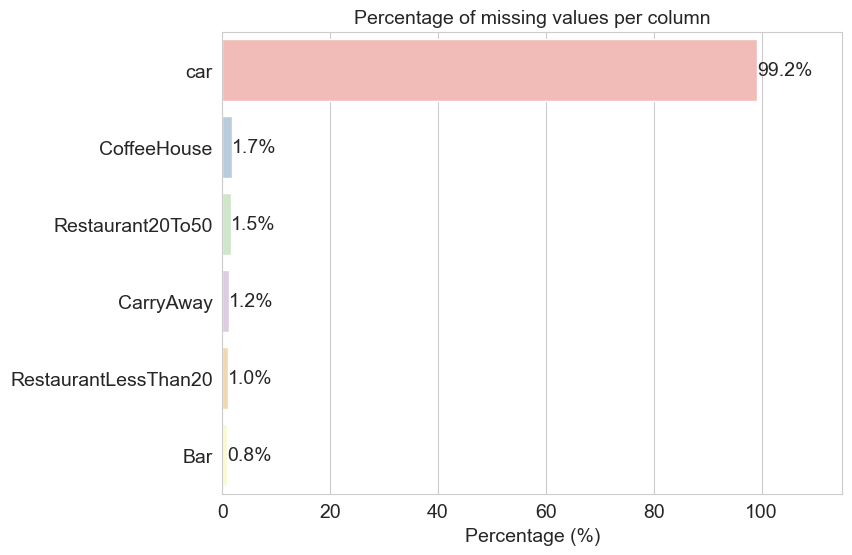

In [11]:
# calculate the percentage of missing values per column
nan_count = df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False)
nan_count_perc = round(nan_count*100./df.shape[0],2)
nan_perc_barplot = sns.barplot(x=nan_count_perc, y=nan_count_perc.index, palette='Pastel1')
plt.bar_label(nan_perc_barplot.containers[0], fmt='%.1f%%', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(0,115)
plt.xlabel('Percentage (%)', fontsize=14)
plt.title('Percentage of missing values per column', fontsize=14)

Missing values are found in the columns Car, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20 and Restaurant20to50.

The car column has more than 99% missing values so it won't be useful. Each of the other five columns have less than 2% missing values.

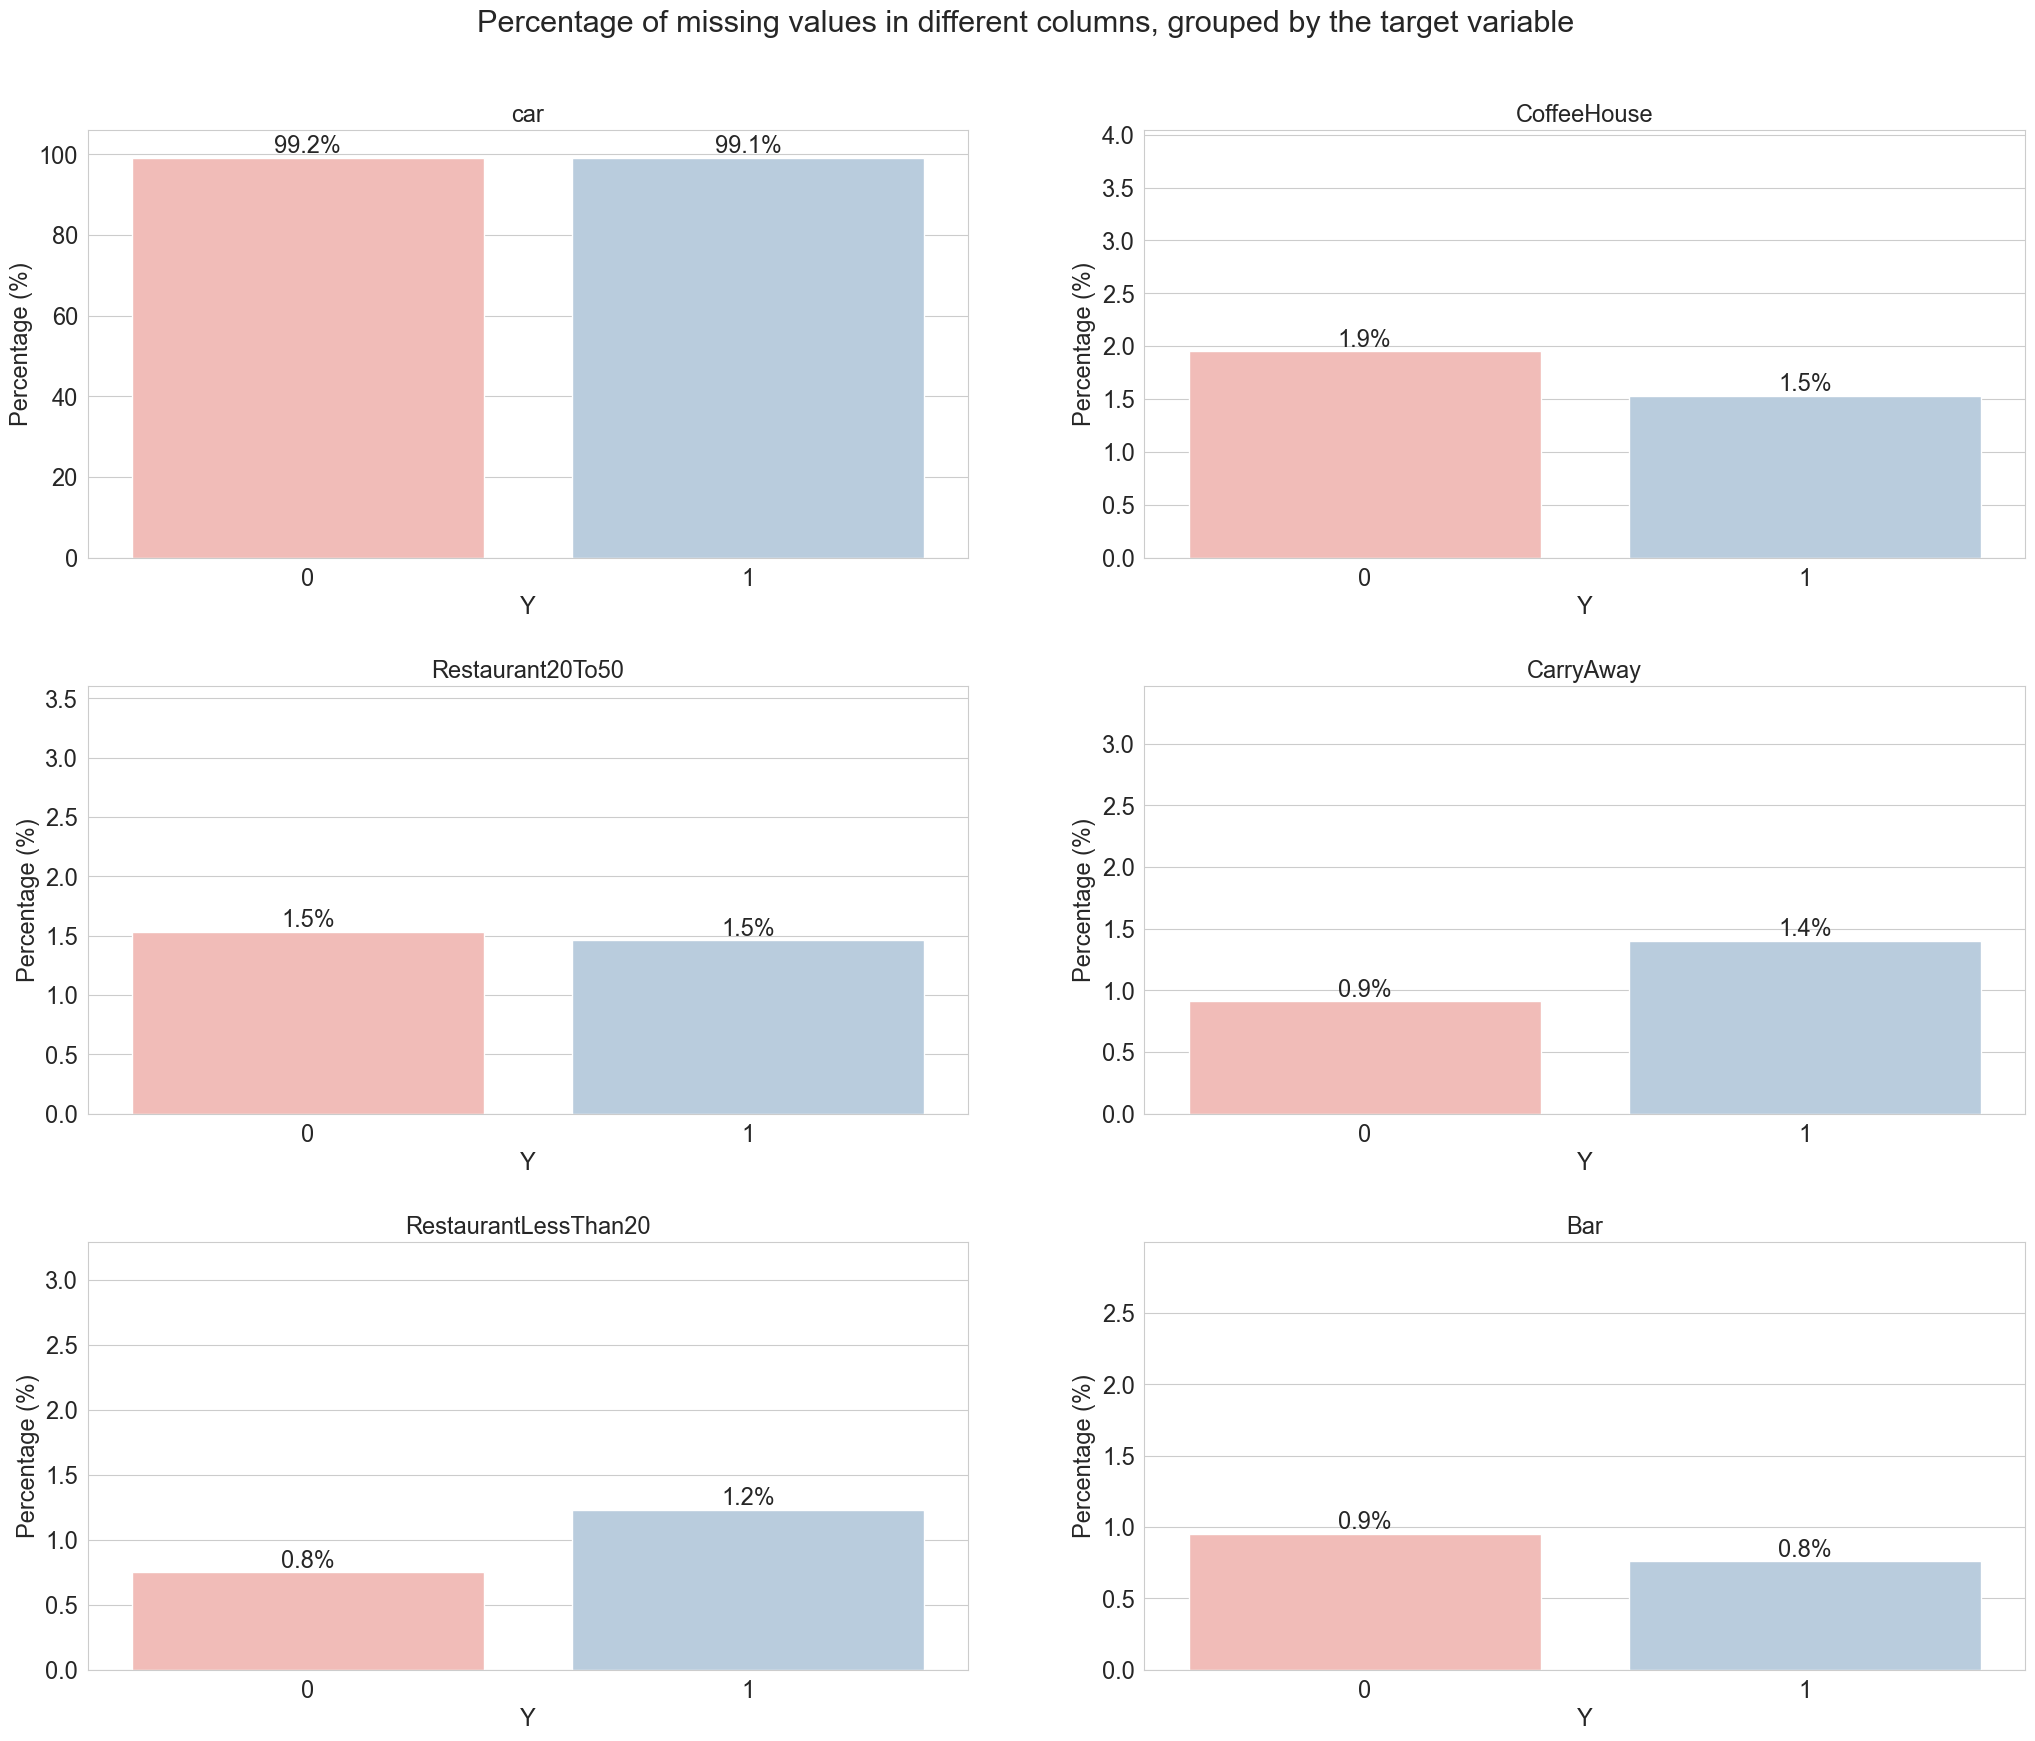

In [12]:
# calculate the percentage of missing values per column, grouped by the target variable
Y_size = df.groupby('Y').size()
i=1
n_cols = 2
plt.figure(figsize=(25,20))
plt.suptitle('Percentage of missing values in different columns, grouped by the target variable', fontsize=22,y=0.94)
for col in nan_count.index:
    nan_count_groupby_Y = df[df[col].isna()].groupby('Y').size()
    nan_count_groupby_Y_perc = round(nan_count_groupby_Y*100./Y_size,2)
    ax = plt.subplot(int(len(nan_count)/n_cols), n_cols, i)
    nan_groupby_Y_perc_barplot = sns.barplot(y=nan_count_groupby_Y_perc, x=nan_count_groupby_Y_perc.index, palette='Pastel1')
    plt.bar_label(nan_groupby_Y_perc_barplot.containers[0], fmt='%.1f%%', fontsize=17)
    plt.yticks(fontsize=17)
    plt.xticks(fontsize=17)
    plt.xlabel('Y', fontsize=17)
    plt.ylabel('Percentage (%)', fontsize=17)
    plt.title(col, fontsize=17)
    bottom, upper = ax.get_ylim()
    ax.set_ylim(bottom, upper+2)
    plt.subplots_adjust(hspace=0.3)
    i=i+1

We can see that missing values appear in both categories of the target variable.

In [13]:
#check the "car" attribute some more
print('Car value count: ')
df["car"].value_counts()

Car value count: 


car
Mazda5                                      22
Scooter and motorcycle                      22
do not drive                                22
Car that is too old to install Onstar :D    21
crossover                                   21
Name: count, dtype: int64

In [14]:
#drop the column "car" because it is redundant - handle (part of) missing values
df = df.drop(['car'], axis=1)

We will use imputation later to not introduce data lekeage, we are just completly removing redundant features in this part

In [15]:
#identify duplicate rows - it is better to check them before the split
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 74


We have 74 rows that are duplicates. We will not exclude them because there is no unique person identifier included in the data so duplicates in the survey seem possible.

The nature of the data is just that many records are identical but they're still legitimate data points. For this project we would want the model to weigh those data points appropriately because in the end that is what the real-world data would look like as well since the data was colected through survey and not artificially created.

In [16]:
#loop to categorize 
#cat include categorical columns,
#num include numeric columns
cat = []
num = []
for col in df.columns: 
    if df[col].dtype == 'category':
        cat.append(col)
    else: 
        num.append(col)

In [17]:
#correlation of features
df[num].corr() # co-variance matrix

,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
has_children,1.000000,NaN,0.078211,-0.013722,-0.031620,0.031620,-0.045557
toCoupon_GEQ5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_GEQ15min,0.078211,NaN,1.000000,0.324984,-0.303533,0.303533,-0.081602
toCoupon_GEQ25min,-0.013722,NaN,0.324984,1.000000,-0.192319,0.192319,-0.103633
direction_same,-0.031620,NaN,-0.303533,-0.192319,1.000000,-1.000000,0.014570
direction_opp,0.031620,NaN,0.303533,0.192319,-1.000000,1.000000,-0.014570
Y,-0.045557,NaN,-0.081602,-0.103633,0.014570,-0.014570,1.000000


Feature ‘direction_same’ is perfectly correlated with ‘direction_opp’ - both have the same variance. They are both Yes/No questions where answering positively to one of them indicates negative answer to another.

In [18]:
# get a count of unique values for each variable - we nee dto check whether there are columns with constant or all unique values
print('Unique values count: ')
df.nunique()

Unique values count: 


destination              3
passanger                4
weather                  3
temperature              3
time                     5
coupon                   5
expiration               2
gender                   2
age                      8
maritalStatus            5
has_children             2
education                6
occupation              25
income                   9
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
toCoupon_GEQ5min         1
toCoupon_GEQ15min        2
toCoupon_GEQ25min        2
direction_same           2
direction_opp            2
Y                        2
dtype: int64

‘toCoupon_GEQ5min’ feature has only one constant value ‘1’ for all data points, which means all establishments are at least more than five minutes away from the driver.

Judging by the value counts, it is clear that all the variables here are qualitative (categorical). Some may be on an ordinal scale. However, it doesn't seem that there are any are continuous numerical values. 

We will drop both 'direction_opp' and 'toCoupon_GEQ5min' features.

In [19]:
# drop the column "toCoupon_GEQ5min" - remove columns with only 1 constant unique value
df = df.drop(columns=['toCoupon_GEQ5min'])

In [20]:
# some more analysis of 'direction_same' and 'direction_opp' features
dfds = pd.DataFrame(sorted(list(df['direction_same'].unique())),columns=['direction_same'])
dfds['Total_Count'] = list(df.groupby('direction_same').Y.count())
dfds['Total_%'] = round(dfds['Total_Count']/df['direction_same'].shape[0]*100,3)
dfds['Accepted'] = list(df[df.Y==1].groupby('direction_same').Y.count())
dfds['Rejected'] = list(df[df.Y==0].groupby('direction_same').Y.count())
dfds['%Accepted'] = round(dfds['Accepted']/dfds['Total_Count']*100,3)
dfds['%Rejected'] = round(dfds['Rejected']/dfds['Total_Count']*100,3)
dfds

,direction_same,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,0,9960,78.524,5624,4336,56.466,43.534
1,1,2724,21.476,1586,1138,58.223,41.777


In [21]:
dfds = pd.DataFrame(sorted(list(df['direction_opp'].unique())),columns=['direction_opp'])
dfds['Total_Count'] = list(df.groupby('direction_opp').Y.count())
dfds['Total_%'] = round(dfds['Total_Count']/df['direction_opp'].shape[0]*100,3)
dfds['Accepted'] = list(df[df.Y==1].groupby('direction_opp').Y.count())
dfds['Rejected'] = list(df[df.Y==0].groupby('direction_opp').Y.count())
dfds['%Accepted'] = round(dfds['Accepted']/dfds['Total_Count']*100,3)
dfds['%Rejected'] = round(dfds['Rejected']/dfds['Total_Count']*100,3)
dfds

,direction_opp,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,0,2724,21.476,1586,1138,58.223,41.777
1,1,9960,78.524,5624,4336,56.466,43.534


In [22]:
# drop the column "direction_opp" - remove highly correlated features
df.drop(columns=['direction_opp'], inplace=True)

We have removed redundant variables

In [23]:
#check the distribution of classes
Y_counts = df.groupby('Y').Y.count()
print('Accepted coupon:',Y_counts[1], round(Y_counts[1]/df.shape[0]*100,3),'%')
print('Rejected coupon:',Y_counts[0], round(Y_counts[0]/df.shape[0]*100,3),'%')

Accepted coupon: 7210 56.843 %
Rejected coupon: 5474 43.157 %


Dataset splitting into train (& validation) dataset and test dataset:  

test dataset will be used only for the final predictions and we assume that during the entire study they do not have access to it and do not study its statistical properties - basically: we will check descriptive statistics and do visualization of only train dataset

Train-test split with stratified approach:
    
to ensure that the proportion of each class in the training and test sets is the same as that in the original dataset

In [24]:
#define x and y
x = df.drop(['Y'], axis=1)
y = df['Y'].values

# train test split
x_main,x_test,y_main,y_test =  train_test_split(x, y, test_size = 0.20, stratify=y, random_state=42)

In [25]:
#create DataFrames, rename Y to target
df_test = x_test, y_test
df_test = pd.DataFrame(data=x_test, columns=df.columns[0:25])
df_test['target'] = y_test

df_train = x_main, y_main
df_train = pd.DataFrame(data=x_main, columns=df.columns[0:25])
df_train['target'] = y_main

In [26]:
#check the dimensionality of training data 
print("Number of instances:", df_train.shape[0])
print("Number of features:", df_train.shape[1])

Number of instances: 10147
Number of features: 24


In [27]:
#check the dimensionality of test data 
print("Number of instances:", df_test.shape[0])
print("Number of features:", df_test.shape[1])

Number of instances: 2537
Number of features: 24


In [28]:
#create a directory 
Path(output_data_path).mkdir(parents=True, exist_ok=True)

#save the DataFrames
df_train.to_csv(f"{output_data_path}/train.csv")
df_test.to_csv(f"{output_data_path}/test.csv")

In [29]:
#rename df_train as df
df = df_train

df.drop(columns=['Y'], inplace=True)
df_test.drop(columns=['Y'], inplace=True)

In [30]:
#check the dimensionality of training data 
print("Number of instances:", df_train.shape[0])
print("Number of features:", df_train.shape[1])
print('*='*100)
print("Attributes of data:")
print(df.columns.values)

Number of instances: 10147
Number of features: 23
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=
Attributes of data:
['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ15min'
 'toCoupon_GEQ25min' 'direction_same' 'target']


In [31]:
#show off sample training data
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,target
9553,Work,Alone,Snowy,30,7AM,Carry out & Take away,1d,Female,below21,Unmarried partner,0,Some college - no degree,Student,$100000 or More,less1,1~3,less1,1~3,less1,1,0,1,1
1394,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,50plus,Widowed,1,High School Graduate,Retired,$12500 - $24999,never,less1,1~3,4~8,less1,1,0,0,0
552,No Urgent Place,Friend(s),Sunny,80,2PM,Restaurant(<20),1d,Female,46,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$37500 - $49999,never,less1,less1,less1,never,1,0,0,1
8377,Home,Alone,Sunny,30,6PM,Carry out & Take away,2h,Female,50plus,Married partner,1,Bachelors degree,Education&Training&Library,$12500 - $24999,less1,4~8,4~8,gt8,less1,1,0,1,1
1353,No Urgent Place,Friend(s),Sunny,55,2PM,Carry out & Take away,1d,Male,26,Unmarried partner,0,Some college - no degree,Sales & Related,$50000 - $62499,1~3,4~8,gt8,1~3,1~3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,No Urgent Place,Friend(s),Sunny,55,2PM,Carry out & Take away,1d,Female,31,Unmarried partner,0,Some college - no degree,Office & Administrative Support,$75000 - $87499,less1,1~3,gt8,4~8,1~3,1,0,0,0
2812,No Urgent Place,Alone,Sunny,55,10AM,Coffee House,2h,Male,below21,Single,0,Some college - no degree,Student,$50000 - $62499,never,1~3,4~8,4~8,less1,0,0,0,1
11414,No Urgent Place,Friend(s),Snowy,30,2PM,Restaurant(<20),1d,Male,31,Married partner,0,Some college - no degree,Sales & Related,$50000 - $62499,1~3,1~3,gt8,4~8,1~3,0,0,0,1
546,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,46,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$37500 - $49999,never,less1,less1,less1,never,0,0,0,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10147 entries, 9553 to 11504
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   destination           10147 non-null  category
 1   passanger             10147 non-null  category
 2   weather               10147 non-null  category
 3   temperature           10147 non-null  category
 4   time                  10147 non-null  category
 5   coupon                10147 non-null  category
 6   expiration            10147 non-null  category
 7   gender                10147 non-null  category
 8   age                   10147 non-null  category
 9   maritalStatus         10147 non-null  category
 10  has_children          10147 non-null  int64   
 11  education             10147 non-null  category
 12  occupation            10147 non-null  category
 13  income                10147 non-null  category
 14  Bar                   10060 non-null  category
 15  Coff

In [33]:
#loop to categorize 
#cat include categorical columns,
#num include numeric columns
cat = []
num = []
for col in df.columns: 
    if df[col].dtype == 'category':
        cat.append(col)
    else: 
        num.append(col)

Descriptive analyses of the data and visualizations of the training data

In [34]:
object_type = []
category_count = 0
int_type = []
features = df.columns
max_cardinality_feature = 0
max_cardinality=-1
for feature in features:
    category_count = category_count + df[feature].nunique()
    if df[feature].nunique()>max_cardinality:
        max_cardinality = df[feature].nunique()
        max_cardinality_feature = feature
    print('Feature --> {} has {} catgories .\nCategories with value count of each are --> \n{}'.format(feature,df[feature].nunique(),df[feature].value_counts()))
    if df[feature].dtype=='O':
        object_type.append(feature)
    else:
        int_type.append(feature)
        
    print('\n')
    print('==*=='*10)
    print('\n')

Feature --> destination has 3 catgories .
Categories with value count of each are --> 
destination
No Urgent Place    5044
Home               2584
Work               2519
Name: count, dtype: int64


==*====*====*====*====*====*====*====*====*====*==


Feature --> passanger has 4 catgories .
Categories with value count of each are --> 
passanger
Alone        5818
Friend(s)    2642
Partner       883
Kid(s)        804
Name: count, dtype: int64


==*====*====*====*====*====*====*====*====*====*==


Feature --> weather has 3 catgories .
Categories with value count of each are --> 
weather
Sunny    8059
Snowy    1122
Rainy     966
Name: count, dtype: int64


==*====*====*====*====*====*====*====*====*====*==


Feature --> temperature has 3 catgories .
Categories with value count of each are --> 
temperature
80    5224
55    3071
30    1852
Name: count, dtype: int64


==*====*====*====*====*====*====*====*====*====*==


Feature --> time has 5 catgories .
Categories with value count of each ar

Occupation is the feature with the highest cardinality having 25 features

In [35]:
#smoe more checking of unique values
print("Occupation:")
print(df['occupation'].value_counts())
print('*='*100)
print("Age:")
print(df['age'].value_counts())
print('*='*100)
print("Income:")
print(df['income'].value_counts())

Occupation:
occupation
Unemployed                                   1504
Student                                      1266
Computer & Mathematical                      1107
Sales & Related                               878
Education&Training&Library                    752
Management                                    655
Arts Design Entertainment Sports & Media      509
Office & Administrative Support               489
Business & Financial                          438
Retired                                       412
Food Preparation & Serving Related            235
Healthcare Practitioners & Technical          200
Healthcare Support                            199
Community & Social Services                   191
Legal                                         188
Transportation & Material Moving              180
Life Physical Social Science                  144
Protective Service                            141
Personal Care & Service                       138
Architecture & Engineering 

In [36]:
print('There are {} integer type attributrs (including the target attribute) .'.format(len(int_type)))
print('Interger type attributes (including the target attribute) are -----> ')
print(*int_type,sep = ',')
print('\n')
print('There are {} Object/string type attributes .'.format(len(int_type)))
print('Object/string type attributes  are ---> ')
print(*object_type,sep = ',')

There are 23 integer type attributrs (including the target attribute) .
Interger type attributes (including the target attribute) are -----> 
destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,target


There are 23 Object/string type attributes .
Object/string type attributes  are ---> 



numeric columns

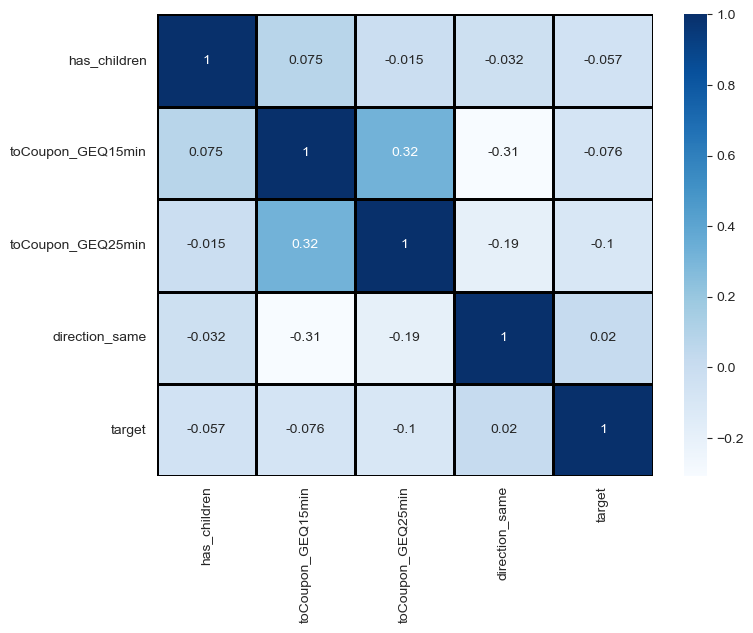

In [37]:
#checking for correlation between the features
df[num].corr()
sns.heatmap(df[num].corr(),annot = True,linecolor='black',linewidths=2, cmap=plt.cm.Blues)
plt.show()

In [38]:
df[num].describe()

,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,target
count,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000
mean,0.413718,0.566473,0.120824,0.213659,0.568444
std,0.492523,0.495586,0.325939,0.409909,0.495318
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


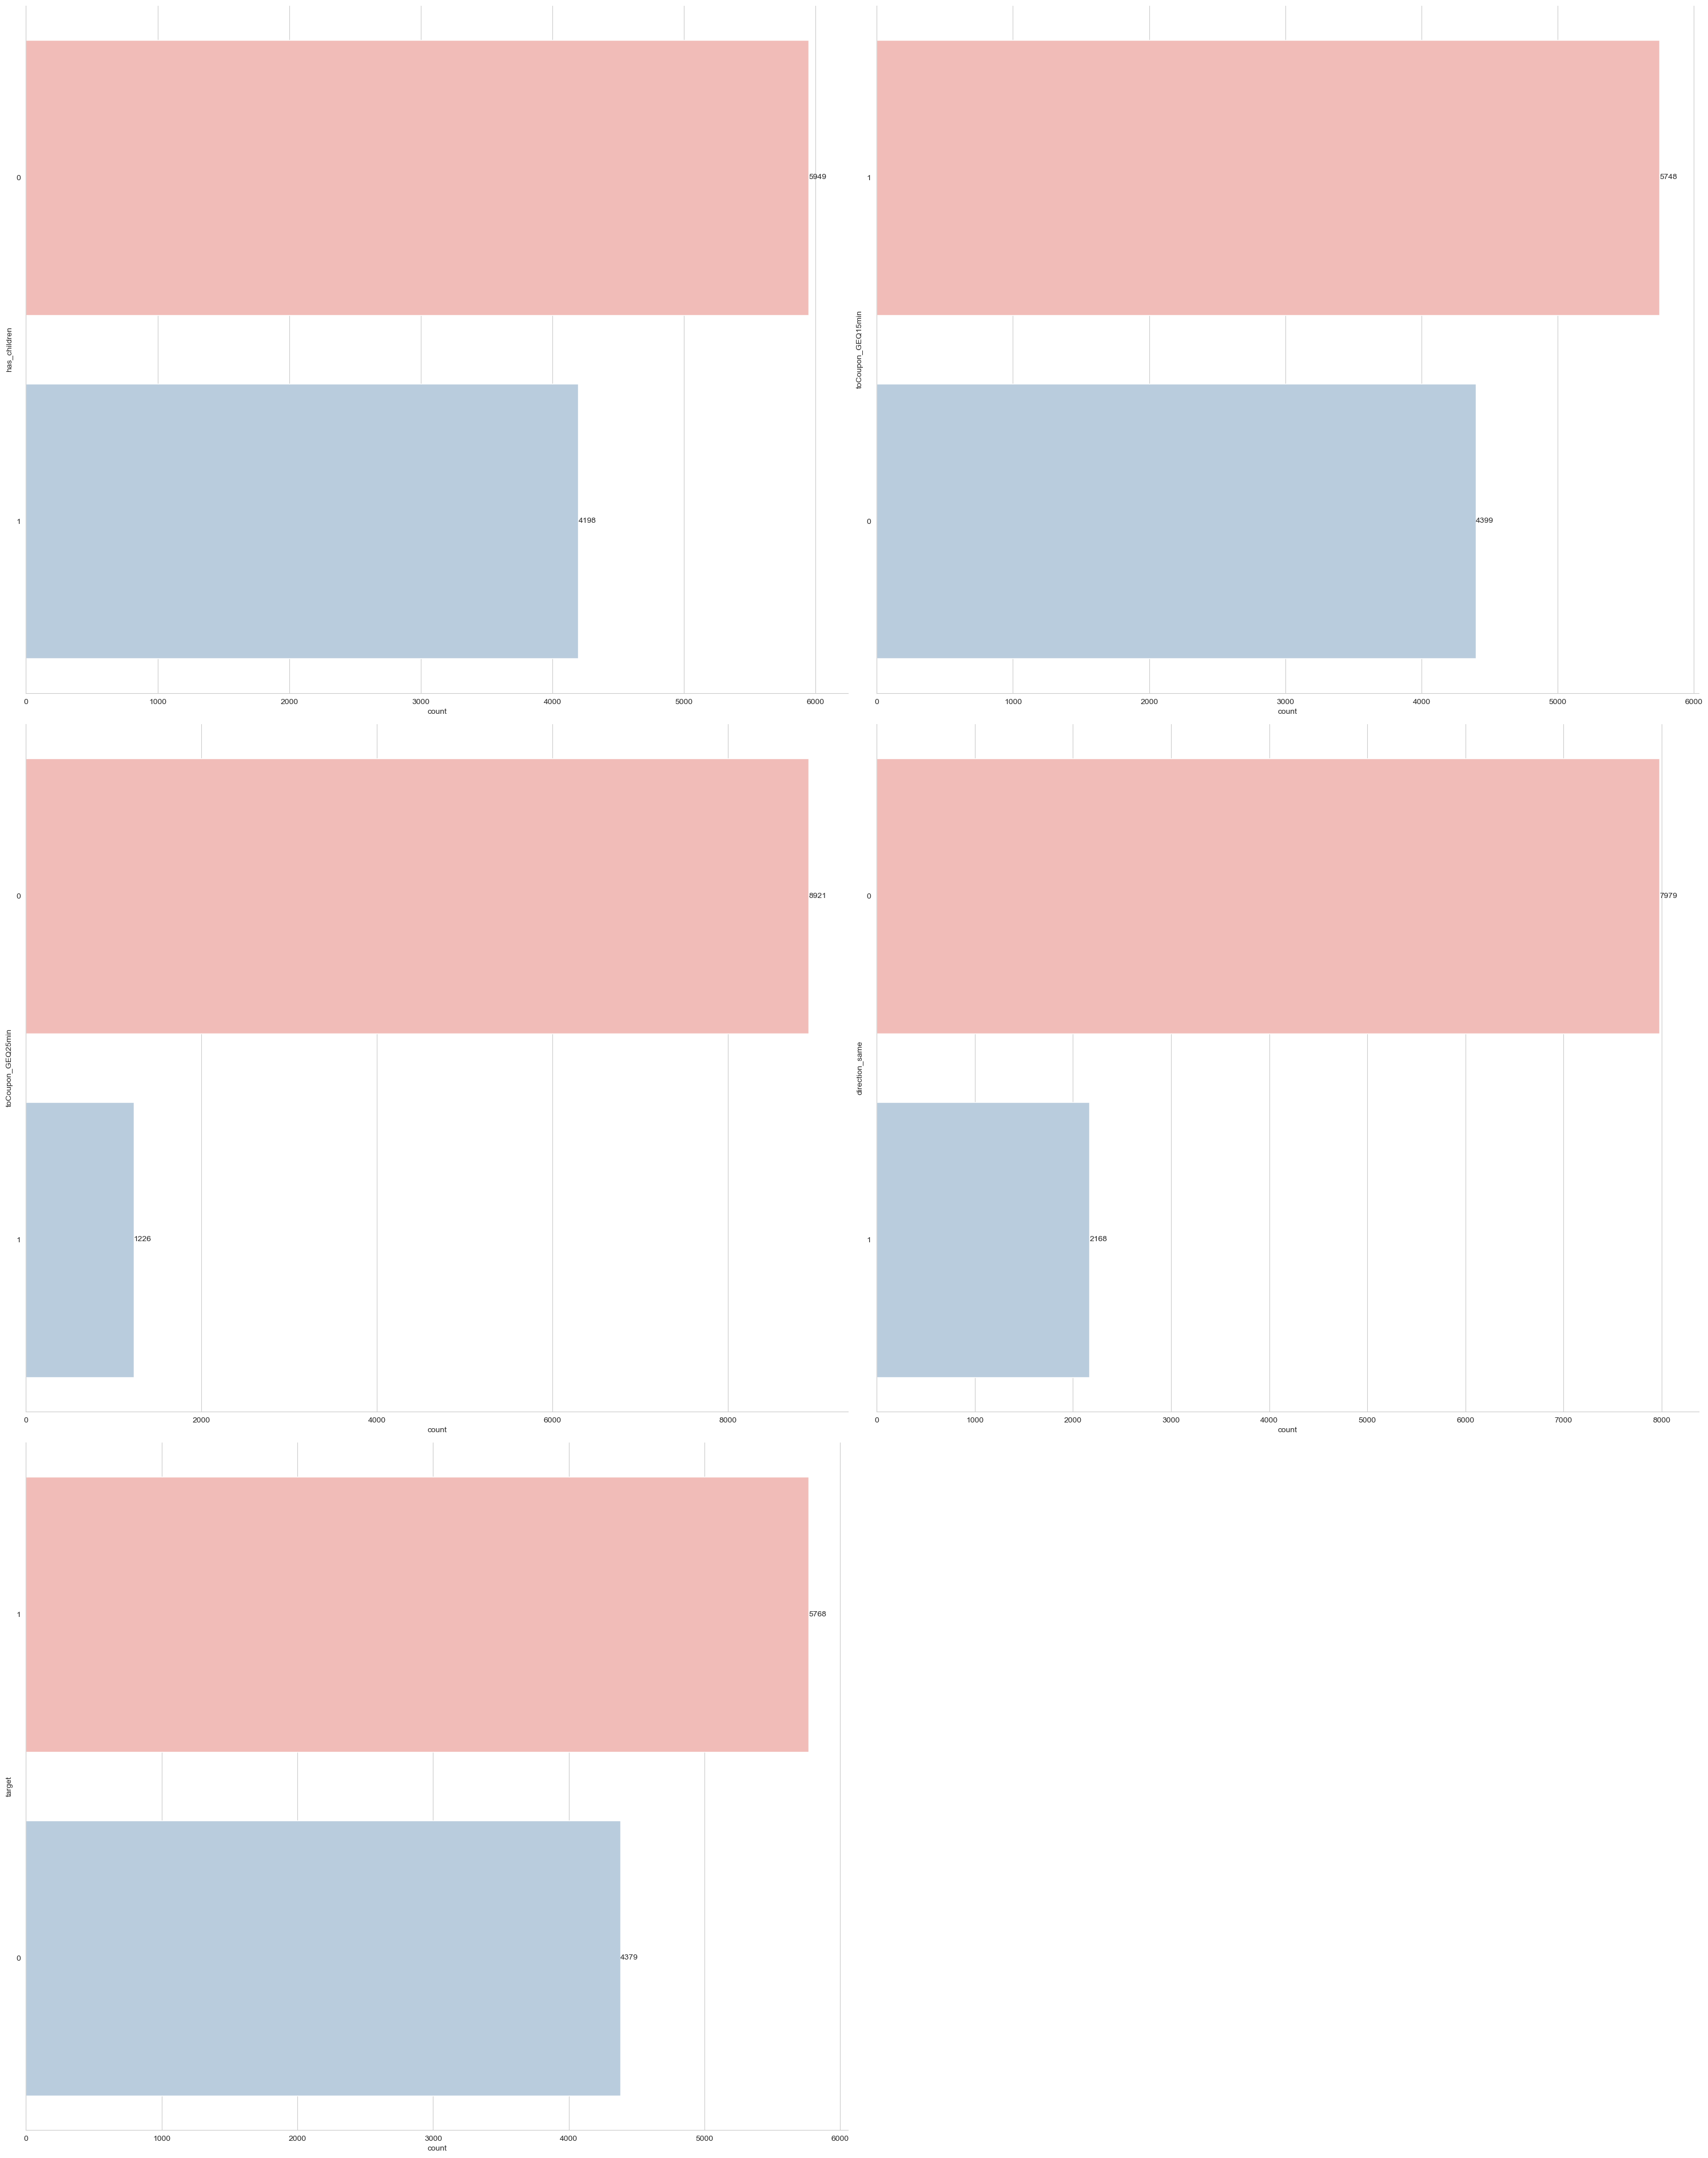

In [39]:
plt.figure(figsize=(30,50))
for i in range(len(num)):
    plt.subplot(4, 2, i+1)
    ax = sns.countplot(y=num[i], data=df, palette='Pastel1', order=df[num[i]].value_counts().index)
    plt.bar_label(ax.containers[0])
    sns.despine()
plt.tight_layout()
plt.show()

categorical columns

In [40]:
df[cat].describe()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50
count,10147,10147,10147,10147,10147,10147,10147,10147,10147,10147,10147,10147,10147,10060,9981,10017,10036,9995
unique,3,4,3,3,5,5,2,2,8,5,6,25,9,5,5,5,5,5
top,No Urgent Place,Alone,Sunny,80,6PM,Coffee House,1d,Female,21,Married partner,Bachelors degree,Unemployed,$25000 - $37499,never,less1,1~3,1~3,less1
freq,5044,5818,8059,5224,2595,3175,5682,5252,2138,4089,3472,1504,1597,4210,2711,3693,4280,4872


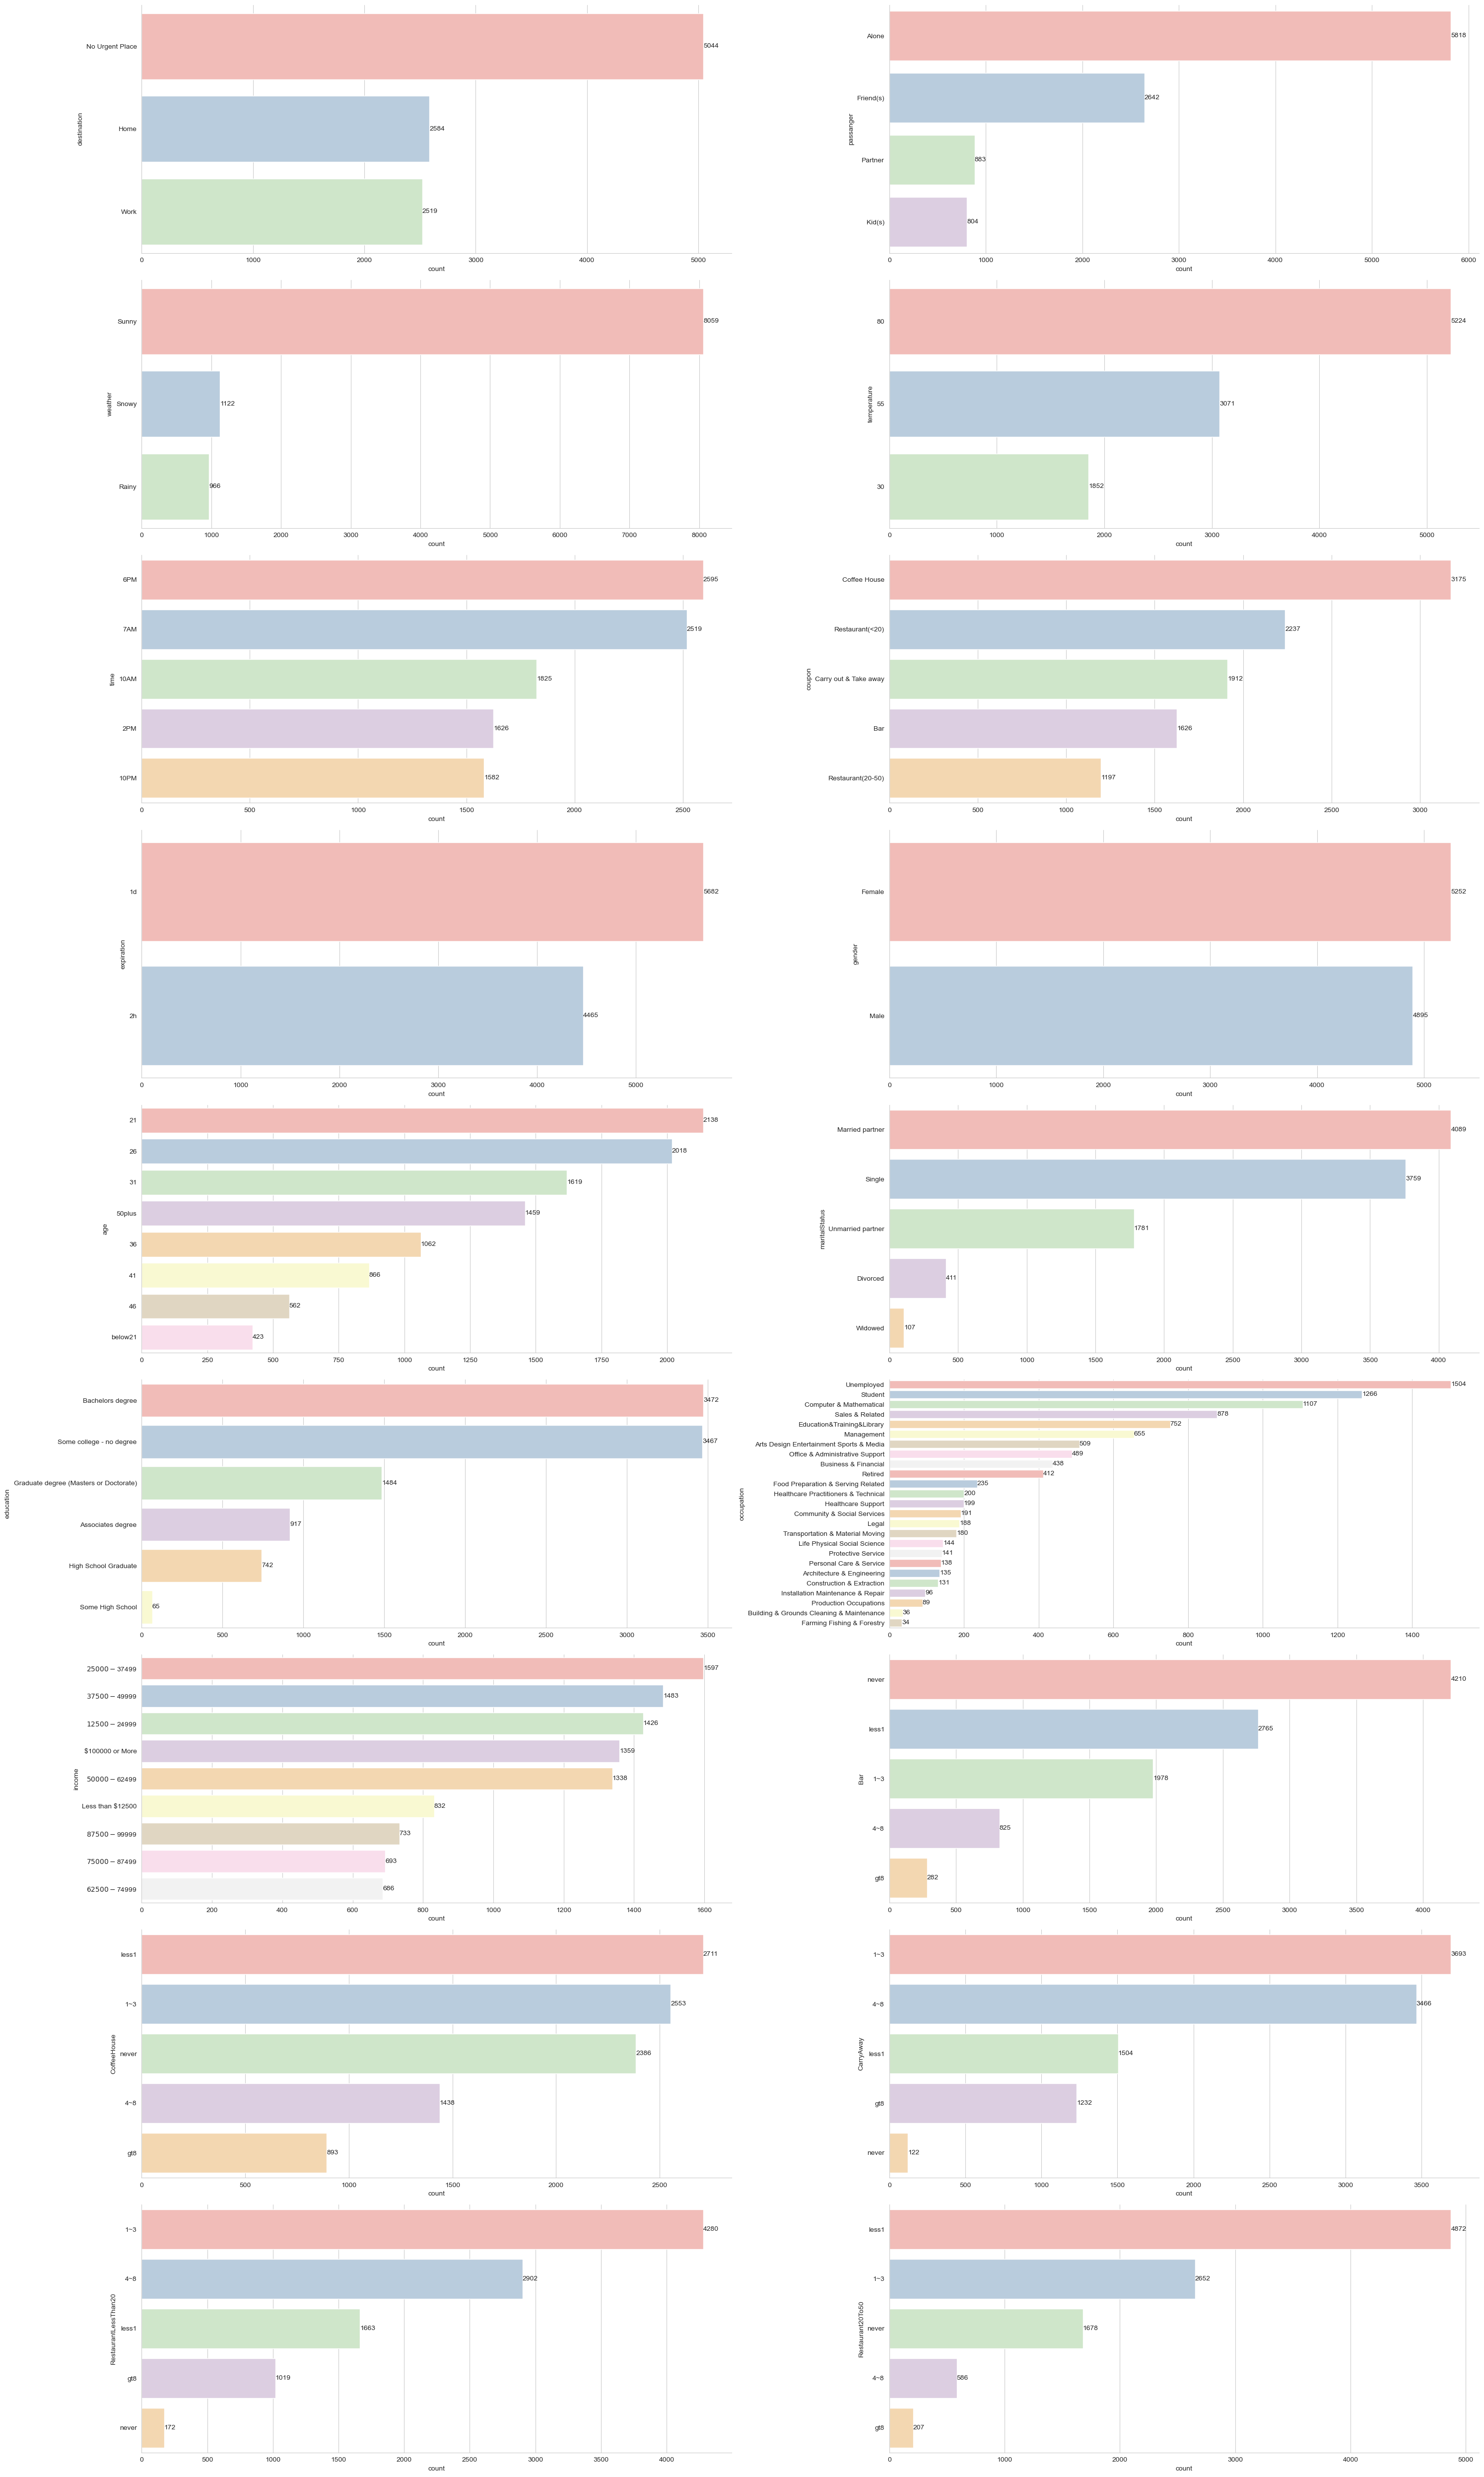

In [41]:
plt.figure(figsize = (30,50))
for i in range(len(cat)):
    plt.subplot(9, 2, i+1)
    ax = sns.countplot(y=cat[i], data=df, palette='Pastel1', order=df[cat[i]].value_counts().index)
    plt.bar_label(ax.containers[0])
    sns.despine()
plt.tight_layout()
plt.show()

In the case of outliers - they are not handled because the data type for each feature is categorical so there are no extreme values other than that the values are still reasonable for further processing.

Univariate analysis

In [42]:
def univar_analysis(feature,fontsize1 = 10,fontsize2 = 9,labelrotation = 45,data = df):
    fig,ax  = plt.subplots(1,2,figsize = (10,7))
    ax = ax.flatten()
    countplot = sns.countplot(data = df,x = df[feature],ax = ax[0],hatch = '/',ec = 'pink')
    for patch in countplot.patches:
        countplot.annotate(patch.get_height(),(patch.get_x(),patch.get_height()),fontsize = fontsize1)
    ax[0].set_title('Count of each category  of {}'.format(feature))
    ax[0].tick_params(axis='x', labelrotation=labelrotation)

    countplot = sns.countplot(data = df,x = df[feature],ax = ax[1],hue = 'target',hatch = '/',ec = 'pink')
    for patch in countplot.patches:
        countplot.annotate(patch.get_height(),(patch.get_x()+0.02,patch.get_height()+1),fontsize = fontsize2)
    ax[1].set_title('Count of each category of {} w.r.t. Y'.format(feature))
    ax[1].tick_params(axis='x', labelrotation=labelrotation)
    plt.subplots_adjust(right=1.5)
    plt.show() 
    
    temp = pd.DataFrame(sorted(list(df[feature].unique())),columns=[feature])
    temp['Total_Count'] = list(df.groupby(feature).target.count())
    Accepted = list(df[df.target==1].groupby(feature).target.count())
    Rejected = list(df[df.target==0].groupby(feature).target.count())
    temp['Acceptance rate'] = round(Accepted/temp['Total_Count']*100,3) 
    temp['Rejection rate'] = round(Rejected/temp['Total_Count']*100,3)
    return  temp

TARGET VARIABLE - DID HE/SHE ACCEPT THE COUPON?

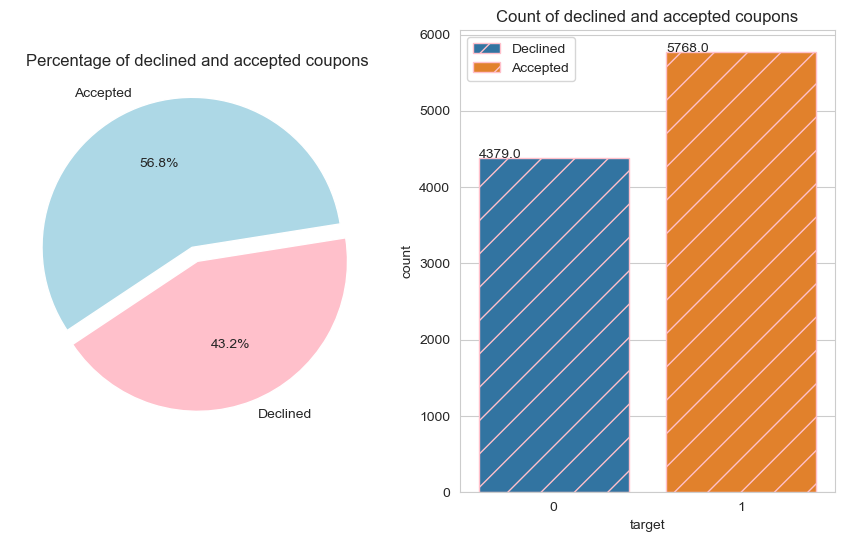

In [43]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize = (6,6))
ax = ax.flatten()

#pie chart
labels = ['Accepted','Declined']
vals = [df[df.target==1]['target'].sum(), len(df[df.target==0]['target'])]
ax[0].pie( vals,labels = labels, startangle=9, autopct='%1.1f%%',explode =( 0.1,0), colors = ['#ADD8E6', '#FFC0CB'])
ax[0].set_title('Percentage of declined and accepted coupons')

#count plot
ax[1].set_title('Count of declined and accepted coupons')
plot = sns.countplot(x = df['target'],ax = ax[1],label = ['Declined','Accepted'],hatch = '/',ec = 'pink')

plot.set_label(['Declined','Accpeted'])
plot.legend()
for patch in plot.patches:
    plot.annotate(patch.get_height(),(patch.get_x(),patch.get_height()+3))
plt.subplots_adjust(right=1.5)
plt.show()

PASSENGERS IN THE CAR

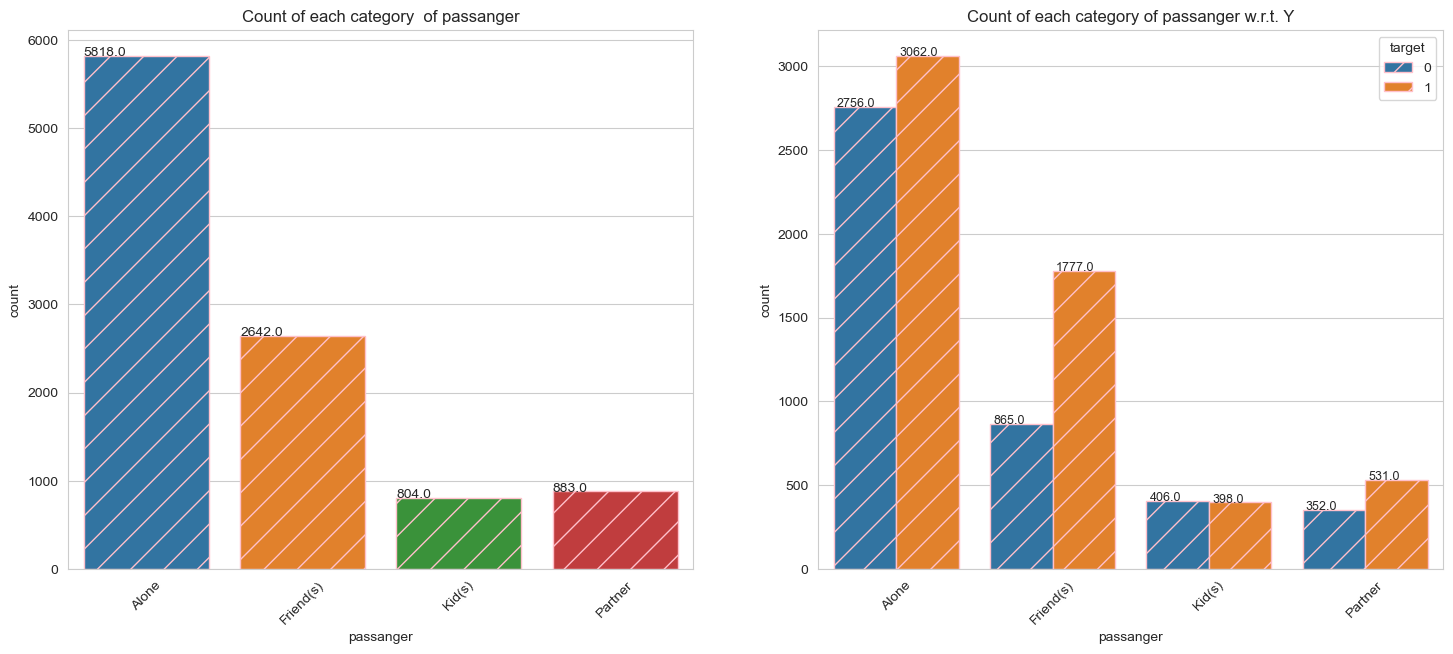

,passanger,Total_Count,Acceptance rate,Rejection rate
0,Alone,5818,52.630,47.370
1,Friend(s),2642,67.260,32.740
2,Kid(s),804,49.502,50.498
3,Partner,883,60.136,39.864


In [44]:
univar_analysis('passanger')

When with friends there is good chance of coupon getting accepted when comapred to being anone,with partner or kids. Most drivers were going outside alone

DESTINATION

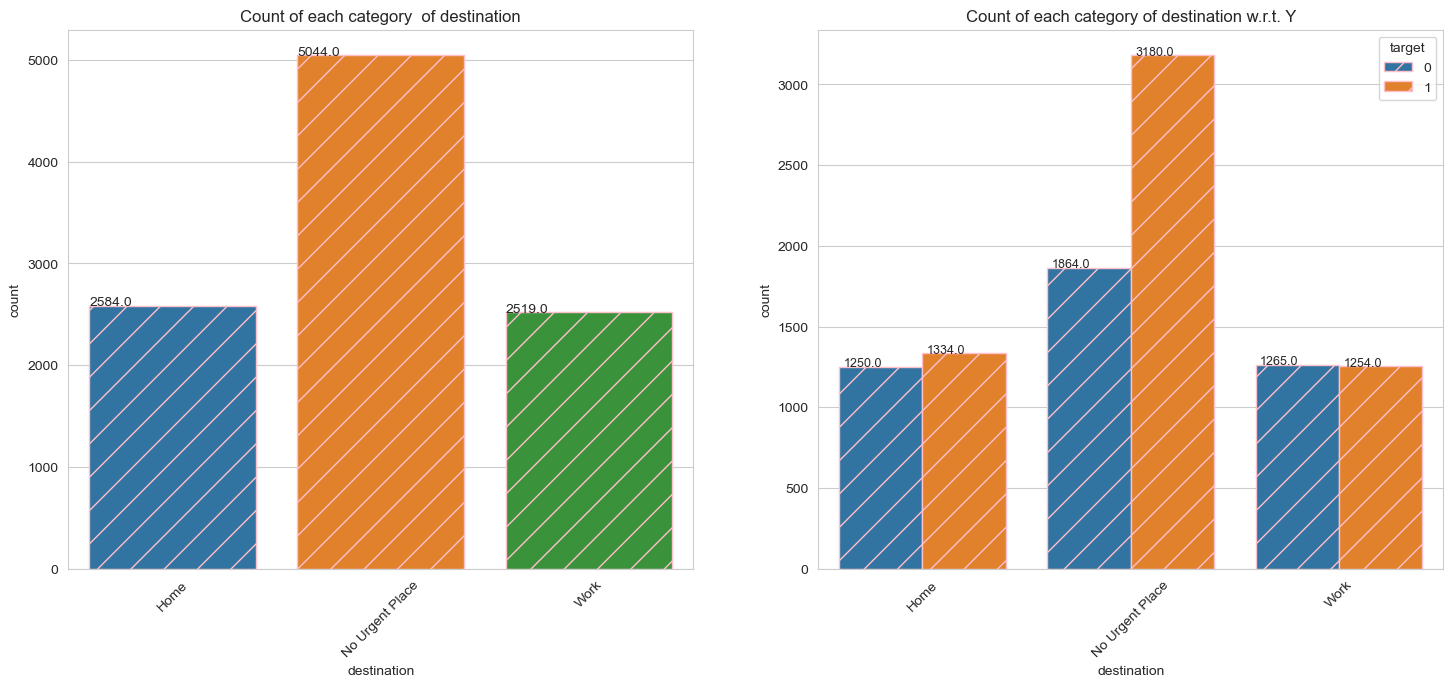

,destination,Total_Count,Acceptance rate,Rejection rate
0,Home,2584,51.625,48.375
1,No Urgent Place,5044,63.045,36.955
2,Work,2519,49.782,50.218


In [45]:
univar_analysis('destination')

Most of the drivers were going to 'no urgent place'- this destination has the highest acceptance rate which means the driver is most likely to accept the coupon when he/she has free time. Destinations 'Home' and 'Work' have similar sort of acceptance rates 

WEATHER

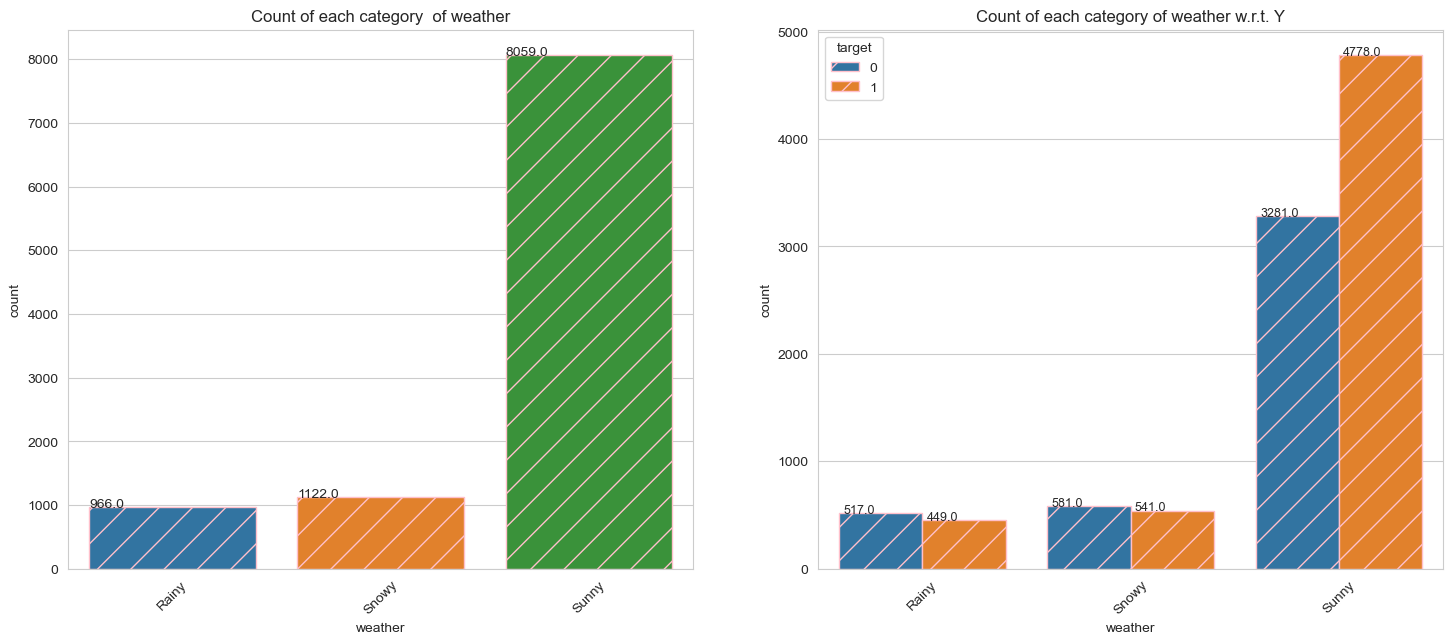

,weather,Total_Count,Acceptance rate,Rejection rate
0,Rainy,966,46.480,53.520
1,Snowy,1122,48.217,51.783
2,Sunny,8059,59.288,40.712


In [46]:
univar_analysis('weather')

The driver will accept the coupon  more often if the weather is clear outside and not raining or snowing outside. Bad weather affects the couon acceptance rate significantly

TEMPERATURE

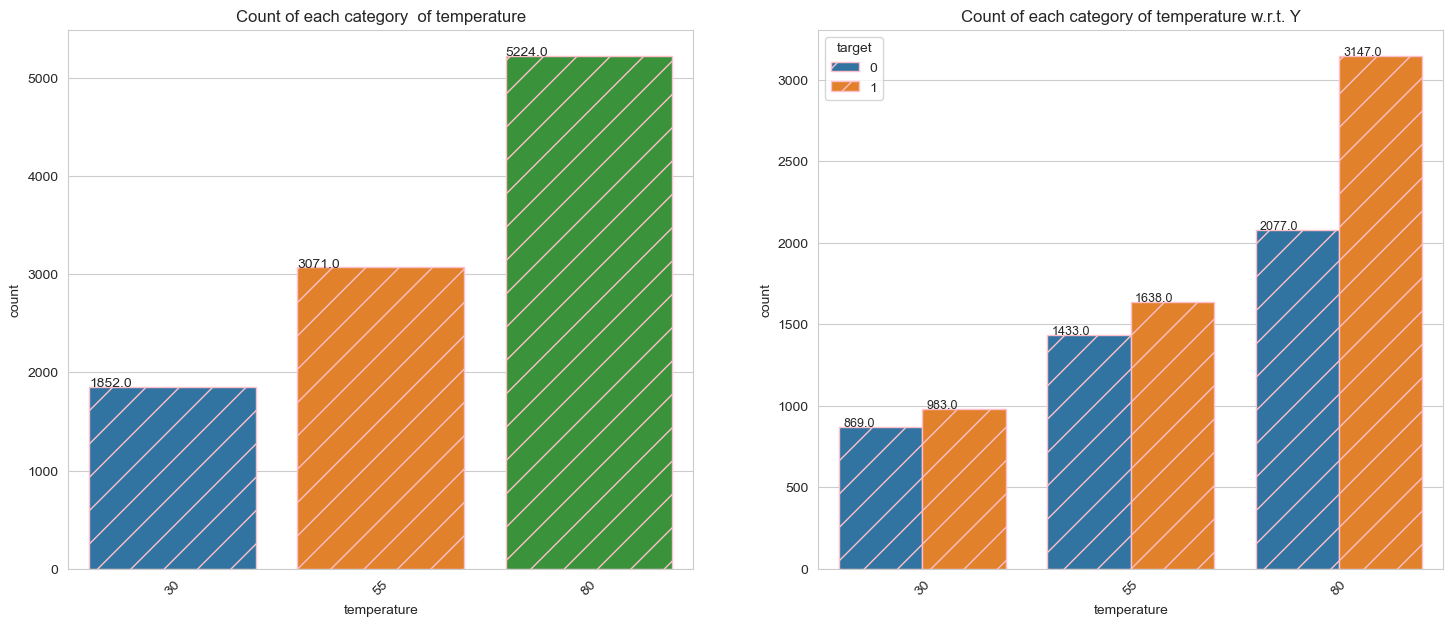

,temperature,Total_Count,Acceptance rate,Rejection rate
0,30,1852,53.078,46.922
1,55,3071,53.338,46.662
2,80,5224,60.241,39.759


In [47]:
univar_analysis('temperature')

For referece 80 F = 26 C , 55 F = 12.7 C ,30 F = -1.11 C

The driver is more likely to accept the coupon if the temperature is on the warmer side 

TIME OF THE DAY

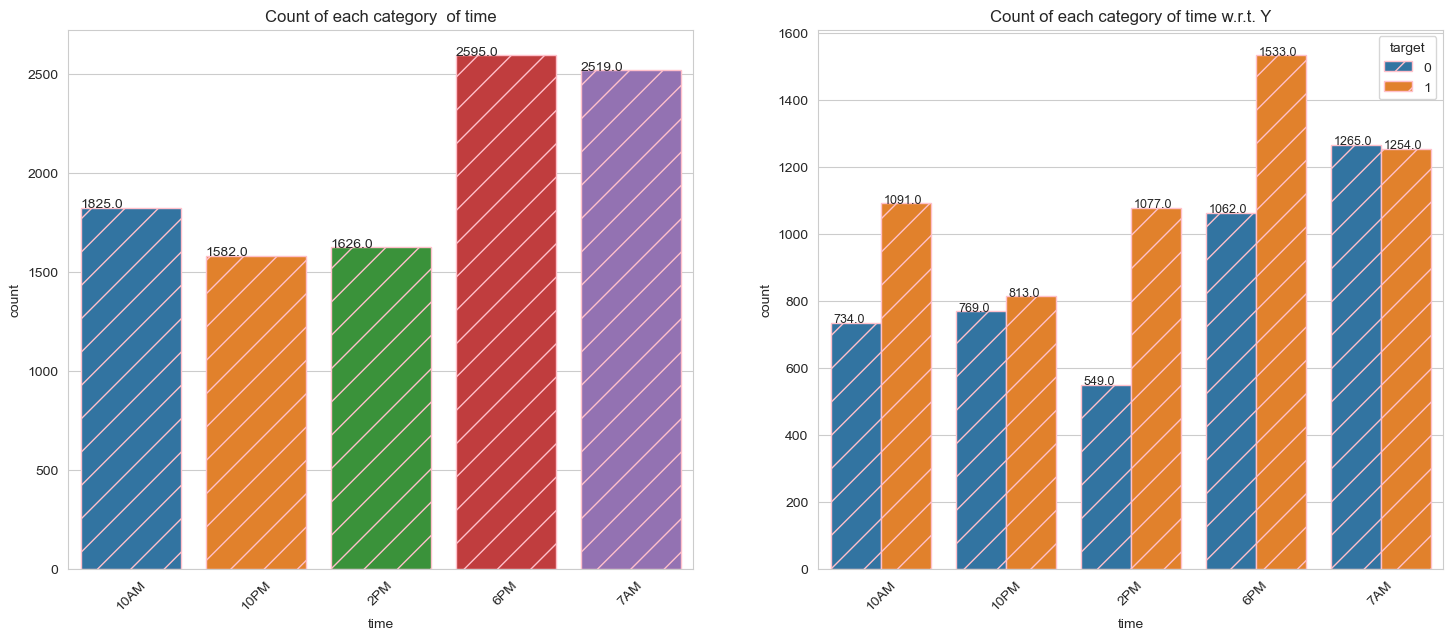

,time,Total_Count,Acceptance rate,Rejection rate
0,10AM,1825,59.781,40.219
1,10PM,1582,51.391,48.609
2,2PM,1626,66.236,33.764
3,6PM,2595,59.075,40.925
4,7AM,2519,49.782,50.218


In [48]:
univar_analysis('time')

6 PM , 2 PM and 7 AM has the heighsest acceptance rate it might be the case because
- 7 AM people go to office/school/work
- 2 PM - Lunch time
- 6 PM - people coming back from office/work

COUPON TYPE

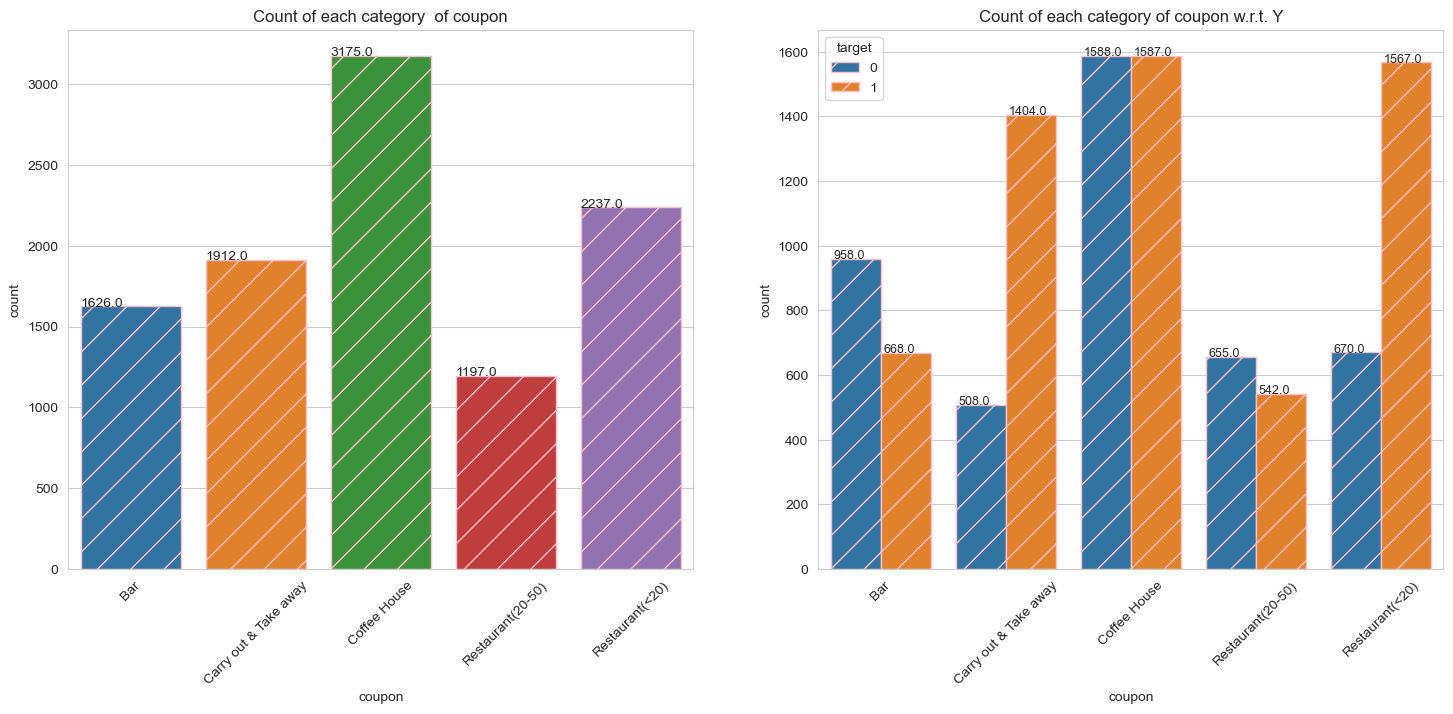

,coupon,Total_Count,Acceptance rate,Rejection rate
0,Bar,1626,41.082,58.918
1,Carry out & Take away,1912,73.431,26.569
2,Coffee House,3175,49.984,50.016
3,Restaurant(20-50),1197,45.280,54.720
4,Restaurant(<20),2237,70.049,29.951


In [49]:
univar_analysis('coupon')

Coupons like 'Restaurant(<20)' and 'Carry out & Take away' have the best acceptance rate. People are more inclined to accept the coupon if driving distance/time is lower. People like to take away the coupons because then they can eat the items in the comfort of their house. 'Bar' coupons are the worst-performing ones. It might be the case because they don't want to drink and then drive

EXPIRATION TIME OF THE COUPON

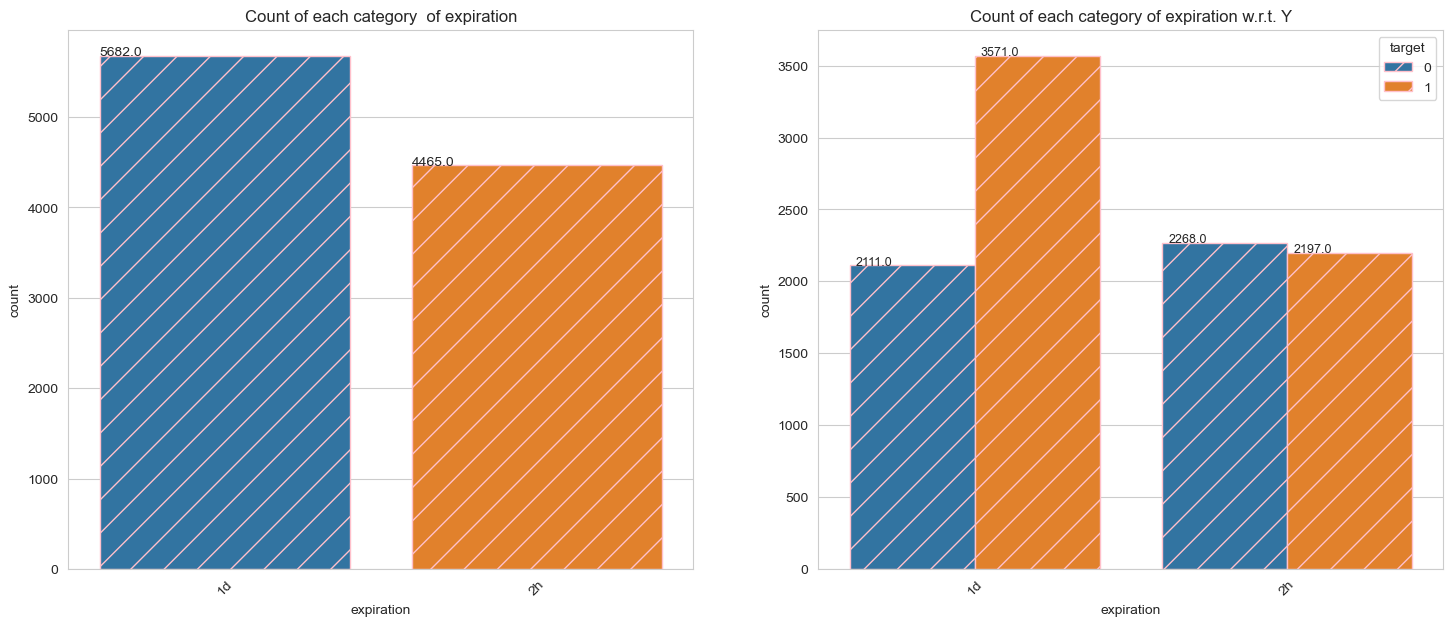

,expiration,Total_Count,Acceptance rate,Rejection rate
0,1d,5682,62.848,37.152
1,2h,4465,49.205,50.795


In [50]:
univar_analysis('expiration')

Coupons with 2h expiry period dont perform very well as there is very less time for the driver. Coupons with expiry period of 1d perform well as the driver has 24hrs to use the coupon


GENDER

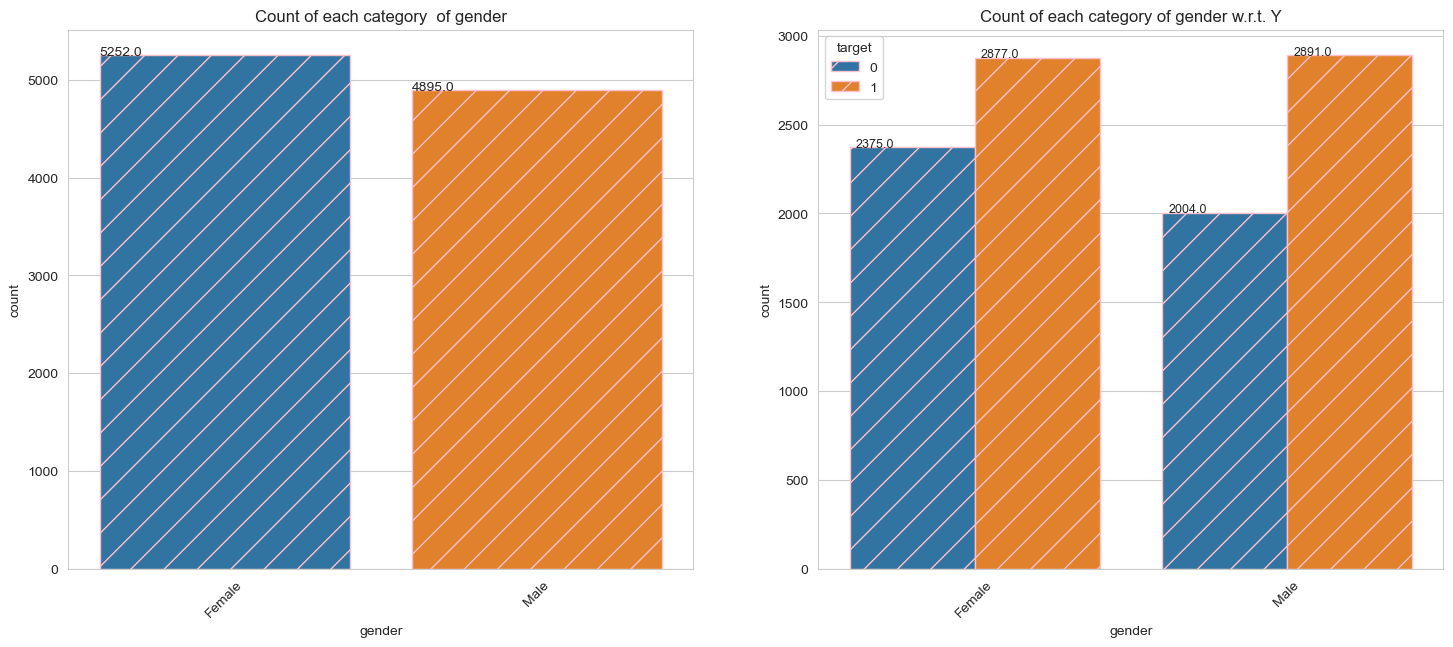

,gender,Total_Count,Acceptance rate,Rejection rate
0,Female,5252,54.779,45.221
1,Male,4895,59.060,40.940


In [51]:
univar_analysis('gender')

Both genders demonstrate nearly identical behaviour, but males are more inclined to take the coupon

AGE

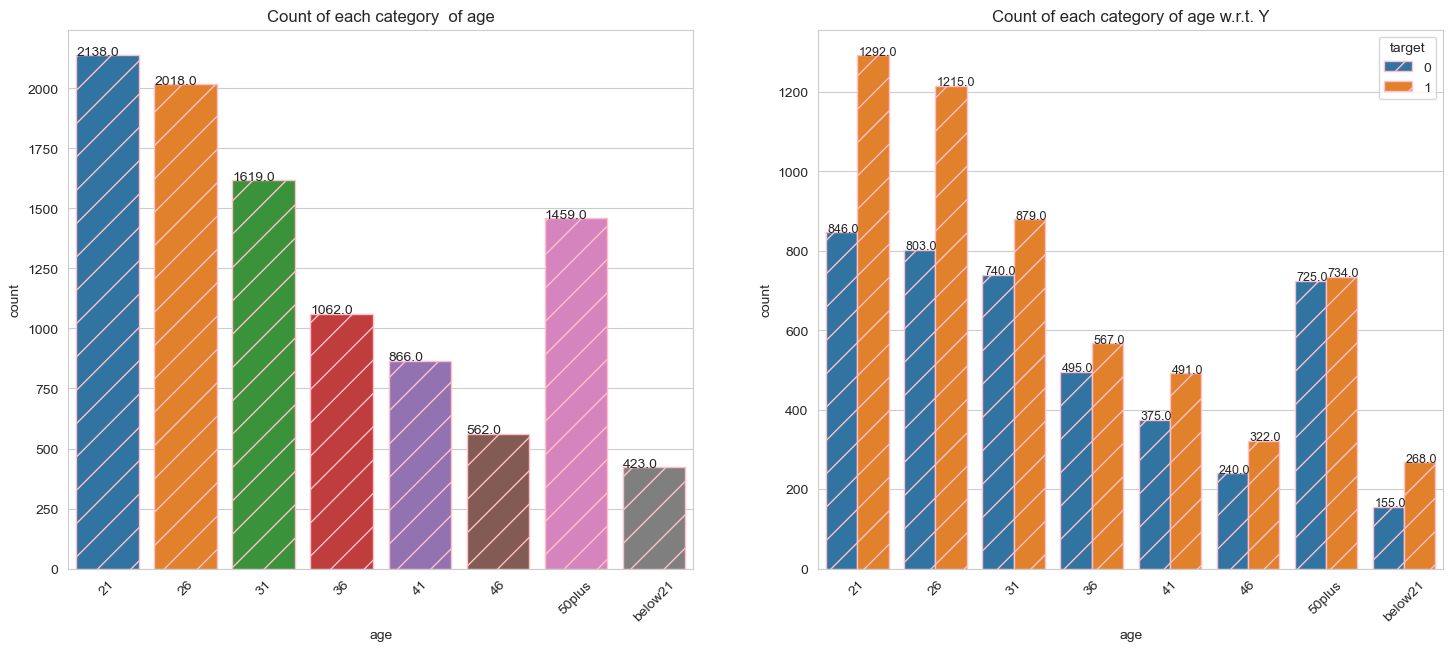

,age,Total_Count,Acceptance rate,Rejection rate
0,21,2138,60.430,39.570
1,26,2018,60.208,39.792
2,31,1619,54.293,45.707
3,36,1062,53.390,46.610
4,41,866,56.697,43.303
5,46,562,57.295,42.705
6,50plus,1459,50.308,49.692
7,below21,423,63.357,36.643


In [52]:
univar_analysis('age')

People of age 'below21' have the best acceptance rate(63.4%). '50plus' have the worst acceptance rate(50.3%).

MARITAL STATUS

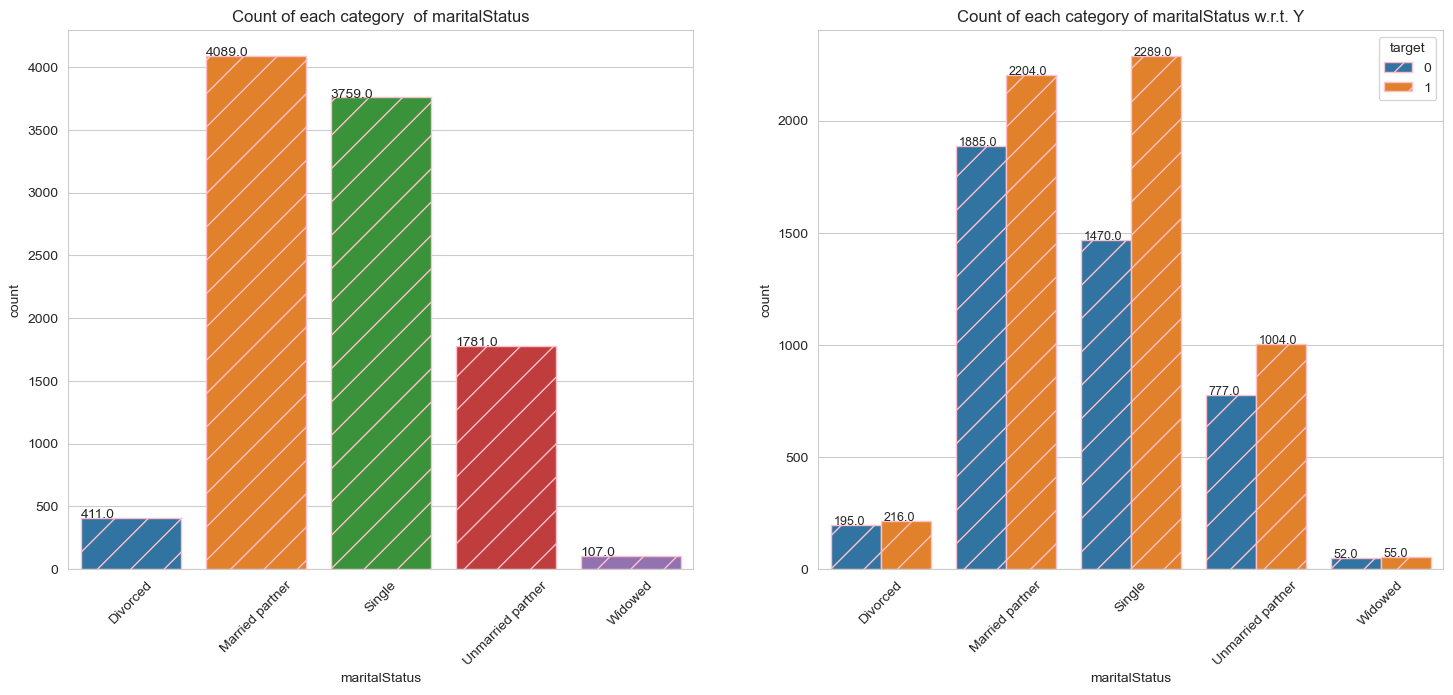

,maritalStatus,Total_Count,Acceptance rate,Rejection rate
0,Divorced,411,52.555,47.445
1,Married partner,4089,53.901,46.099
2,Single,3759,60.894,39.106
3,Unmarried partner,1781,56.373,43.627
4,Widowed,107,51.402,48.598


In [53]:
univar_analysis('maritalStatus')

Single drivers accept more coupons than the couples. Most of the drivers were single or married



DOES HE/SHE HAVE CHILDREN?

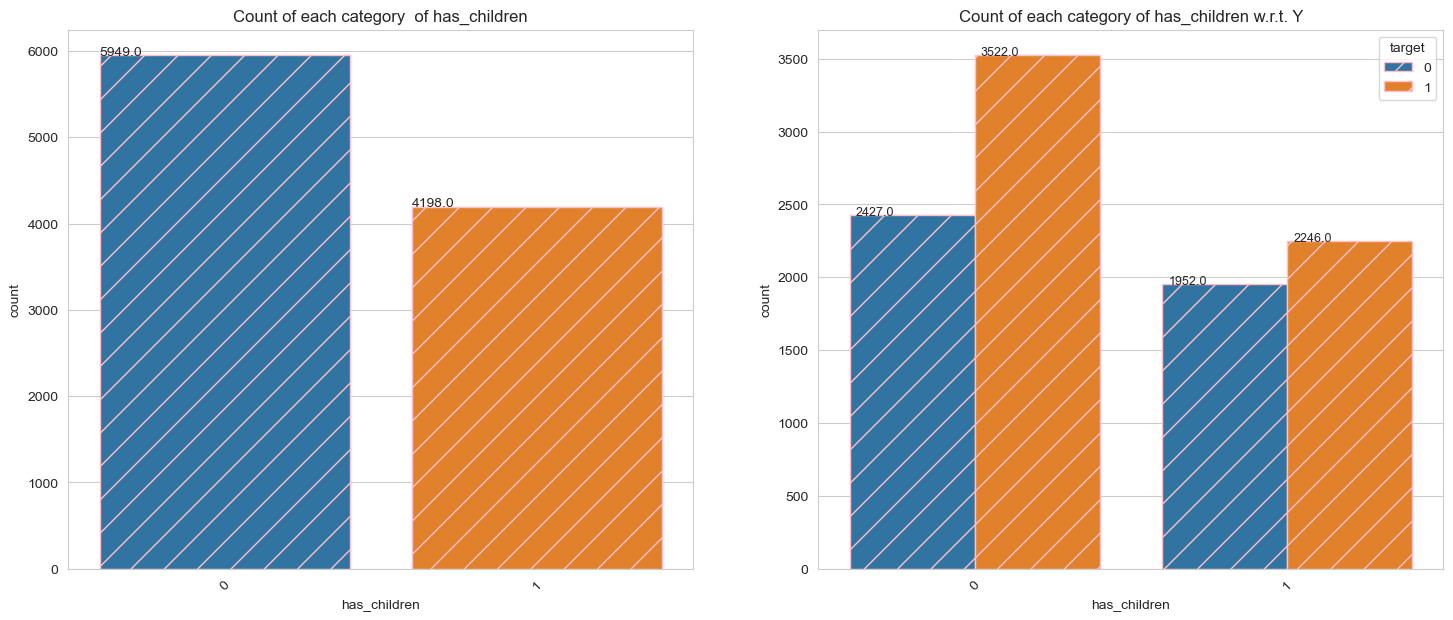

,has_children,Total_Count,Acceptance rate,Rejection rate
0,0,5949,59.203,40.797
1,1,4198,53.502,46.498


In [54]:
univar_analysis('has_children')

Drivers who don't have any children accept more coupons

EDUCATION

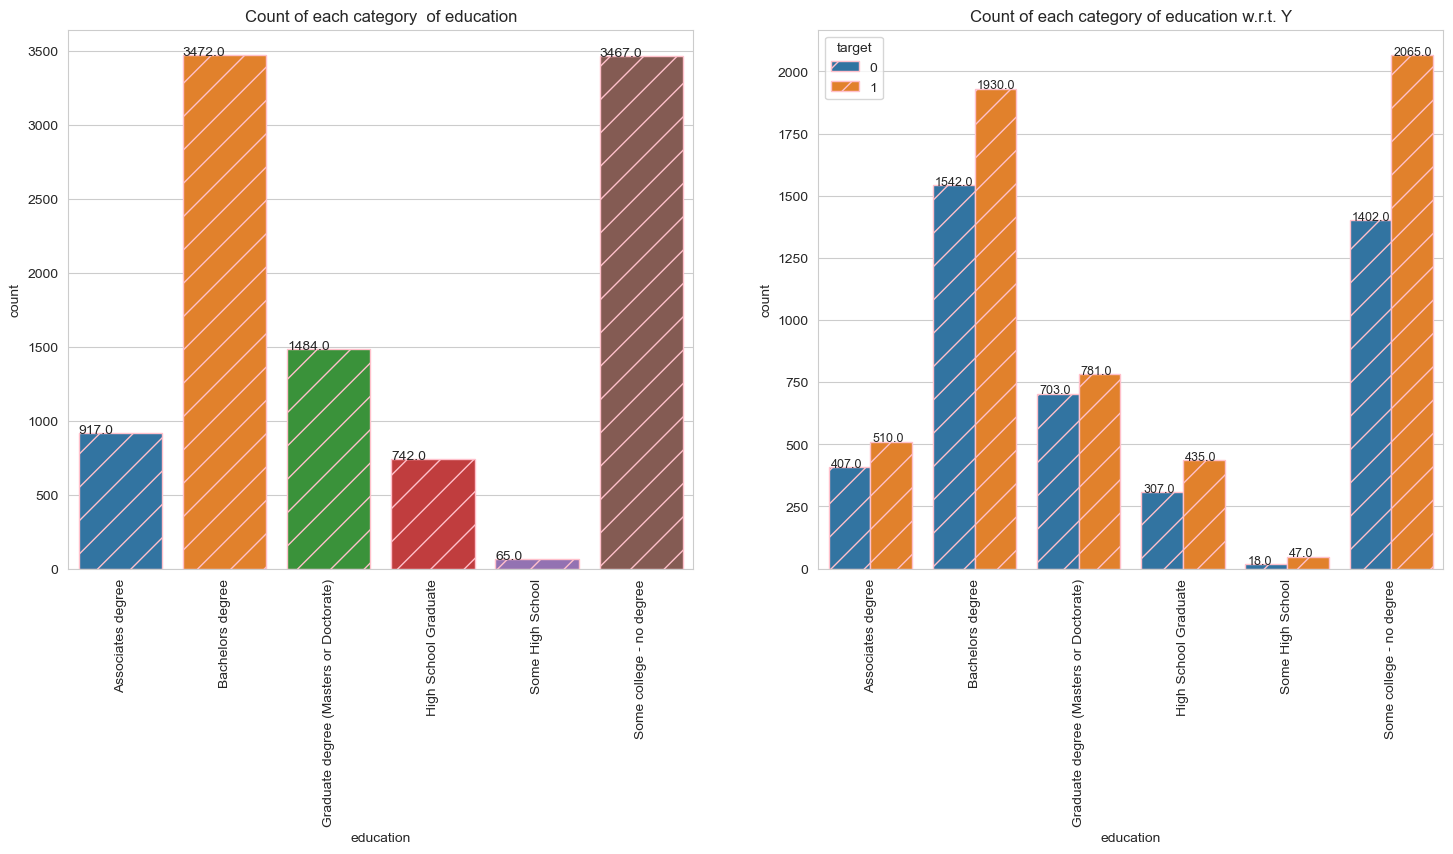

,education,Total_Count,Acceptance rate,Rejection rate
0,Associates degree,917,55.616,44.384
1,Bachelors degree,3472,55.588,44.412
2,Graduate degree (Masters or Doctorate),1484,52.628,47.372
3,High School Graduate,742,58.625,41.375
4,Some High School,65,72.308,27.692
5,Some college - no degree,3467,59.562,40.438


In [55]:
univar_analysis('education',labelrotation=90)

Most of the drivers had an education level of 'Some college - no degree' or 'Bachelors degree'
'Some High School' has the best acceptance rate.'Graduate degree (Masters or Doctorate)' holders has the lowest acceptance rate


ANNUAL INCOME

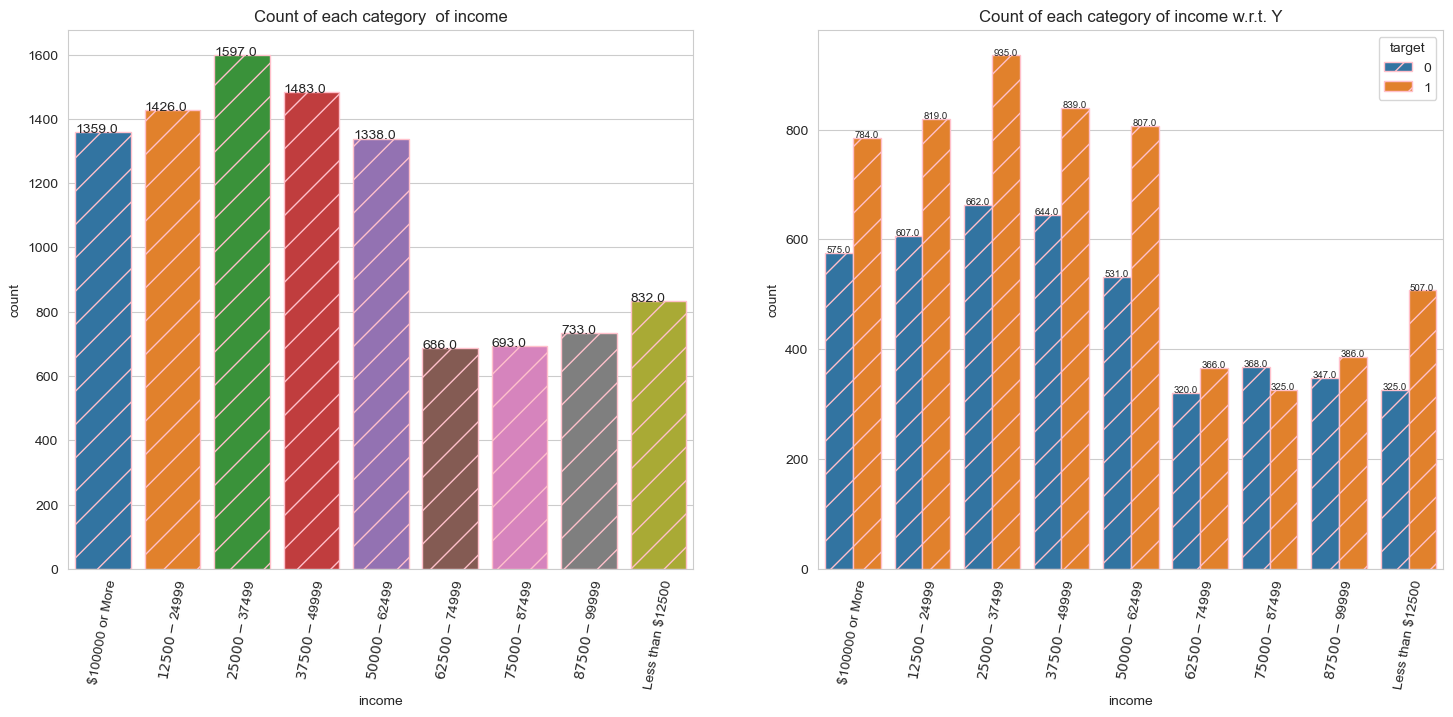

,income,Total_Count,Acceptance rate,Rejection rate
0,$100000 or More,1359,57.689,42.311
1,$12500 - $24999,1426,57.433,42.567
2,$25000 - $37499,1597,58.547,41.453
3,$37500 - $49999,1483,56.575,43.425
4,$50000 - $62499,1338,60.314,39.686
5,$62500 - $74999,686,53.353,46.647
6,$75000 - $87499,693,46.898,53.102
7,$87500 - $99999,733,52.660,47.340
8,Less than $12500,832,60.938,39.062


In [56]:
univar_analysis('income',labelrotation=80,fontsize2=7)

Drivers with income 75000−87499 have the lowest acceptance rate. Less than $12500 has the highest acceptance rate

In [57]:
def univar_analysis(feature,fontsize1 = 10,fontsize2 = 9,labelrotation = 45,data = df):
    fig,ax  = plt.subplots(1,2,figsize = (10,7))
    ax = ax.flatten()
    countplot = sns.countplot(data = df,x = df[feature],ax = ax[0],hatch = '/',ec = 'pink')
    for patch in countplot.patches:
        countplot.annotate(patch.get_height(),(patch.get_x(),patch.get_height()),fontsize = fontsize1)
    ax[0].set_title('Count of each category  of {}'.format(feature))
    ax[0].tick_params(axis='x', labelrotation=labelrotation)

    countplot = sns.countplot(data = df,x = df[feature],ax = ax[1],hue = 'target',hatch = '/',ec = 'pink')
    for patch in countplot.patches:
        countplot.annotate(patch.get_height(),(patch.get_x()+0.02,patch.get_height()+1),fontsize = fontsize2)
    ax[1].set_title('Count of each category of {} w.r.t. Y'.format(feature))
    ax[1].tick_params(axis='x', labelrotation=labelrotation)
    plt.subplots_adjust(right=1.5)
    plt.show()

BAR

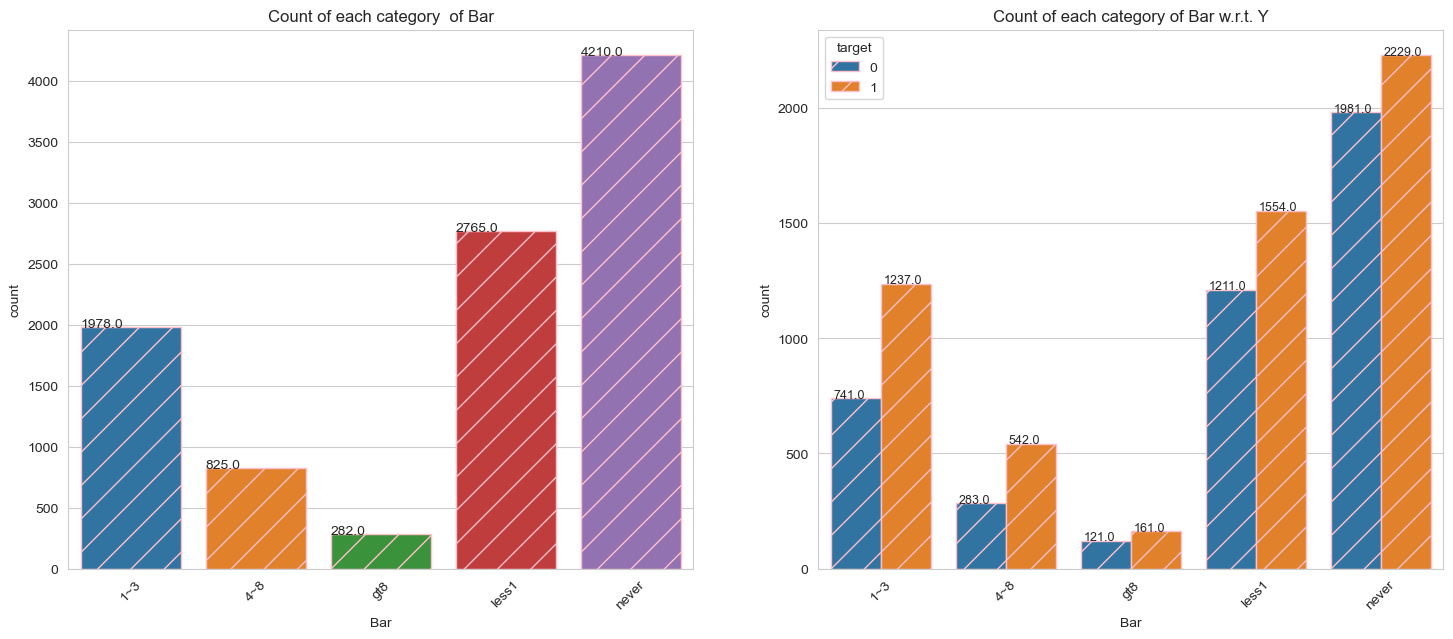

In [58]:
univar_analysis('Bar')

Most people have never visited the bar. Very few people visited the bar more than 8 times in a month. People visiting the bar 1~3,4~8 times in a month have the highest coupon acceptance rate



In [59]:
COFFEE HOUSE

SyntaxError: invalid syntax (3518575574.py, line 1)

In [ ]:
univar_analysis('CoffeeHouse')

Most of the people visited the CoffeeHouse less than 1 time every month. People going to the coffeehouse 1~3 and 4~8 times every month are more likely to accept the coupon



CARRY AWAY

In [ ]:
univar_analysis('CarryAway',fontsize2=9)

Taking Carry Away food seems to be normal as very few people get takeaway food every month less than 1 time and never. Majority of people get CarryAway food 1~8 times per month



RestaurantLessThan20

In [ ]:
univar_analysis('RestaurantLessThan20',fontsize2=9)

If the usual cost for an individual is around 50 a month, then those who go to the restaurant more than 8 times tend to have a very high acceptance rate of coupons. People who visit Restaurant with average cost less than 20 frequently has good acceptance rate

Restaurant20To50

In [ ]:
univar_analysis('Restaurant20To50')

Frequent visitors are more likely to accept the coupon even if the average cost per person is 20 to 50 dollars

'toCoupon_GEQ15min' & 'toCoupon_GEQ25min'

In [ ]:
for feature in ['toCoupon_GEQ15min','toCoupon_GEQ25min']:
    print(univar_analysis(feature,fontsize1=11,fontsize2=11))
    print('\n')
    print('=*='*40)

The amount of time it takes to drive to the restaurant or bar in order to redeem the coupon is an essential element for coupon acceptance.The restaurant close by has a higher rate of acceptance.When the drive to the restaurant/bar was longer than 25 minutes, not many coupons were not recommended.


OCCUPATION

In [ ]:
# set a pastel color palette
pastel_palette = sns.color_palette("pastel")
# set the figure size
plt.figure(figsize=(12, 8))
# create the count plot with pastel colors
sns.countplot(y=df.occupation, hue=df.target, palette=pastel_palette, edgecolor='pink')
# add labels and title if needed
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.title('Count of each occupation with respect to Y')
# show the plot
plt.show()

Many people are un employed or students. Very feq people work in in Farming Fishing and Forestry , Building and ground maintaince

Some more target variable analysis

In [ ]:
# calculate and plot the acceptance rate per coupon type
groupby_col = df.groupby('coupon')['target'].value_counts(normalize=True).mul(100).rename('Percentage (%)').reset_index()
g = sns.barplot(y='coupon', x='Percentage (%)', orient="h", 
                data=groupby_col[groupby_col['target']==1].sort_values('Percentage (%)', ascending=False), palette='Pastel1')
left, right = g.get_xlim()
g.set_xlim(left,right+4)
g.set_ylabel('')
g.set_title('Acceptance rate per coupon type\n', fontsize=17)
g.set_xlabel('Percentage (%)', fontsize = 12)
for container in g.containers:
    g.bar_label(container, fmt='%.1f%%', fontsize=12)

The coupon Carry out & Take away has the highest acceptance rate, closely followed by the coupon Restaurant(<20).

The coupon Bar has the highest decline rate, closely followed by the coupon Restaurant(20-50).

Now we will use imputation 

In [60]:
# mode imputation for missing values
df['Bar'] = df['Bar'].fillna(df['Bar'].value_counts().index[0])
df['CoffeeHouse'] = df['CoffeeHouse'].fillna(df['CoffeeHouse'].value_counts().index[0])
df['CarryAway'] = df['CarryAway'].fillna(df['CarryAway'].value_counts().index[0])
df['RestaurantLessThan20'] = df['RestaurantLessThan20'].fillna(df['RestaurantLessThan20'].value_counts().index[0])
df['Restaurant20To50'] = df['Restaurant20To50'].fillna(df['Restaurant20To50'].value_counts().index[0])

In [61]:
# we need to apply it to test data individually
df_test['Bar'] = df_test['Bar'].fillna(df_test['Bar'].value_counts().index[0])
df_test['CoffeeHouse'] = df_test['CoffeeHouse'].fillna(df_test['CoffeeHouse'].value_counts().index[0])
df_test['CarryAway'] = df_test['CarryAway'].fillna(df_test['CarryAway'].value_counts().index[0])
df_test['RestaurantLessThan20'] = df_test['RestaurantLessThan20'].fillna(df_test['RestaurantLessThan20'].value_counts().index[0])
df_test['Restaurant20To50'] = df_test['Restaurant20To50'].fillna(df_test['Restaurant20To50'].value_counts().index[0])

In [62]:
#chacking if theres any missing value now after imputation
df.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
target                  0
dtype: int64

In [63]:
#test data
df_test.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
target                  0
dtype: int64

Feature engineering

to_Coupon

In [64]:
#to_Coupon is combination of two features, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in range(df.shape[0]):
    if (list(df['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(df['toCoupon_GEQ15min'])[i] == 1)and(list(df['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
df['to_Coupon'] = to_Coupon
print('Unique values:',df['to_Coupon'].unique())
print('-'*50)
df['to_Coupon'].describe()

Unique values: [1 0 2]
--------------------------------------------------


count    10147.000000
mean         0.687297
std          0.675731
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: to_Coupon, dtype: float64

In [65]:
# test
to_Coupon = []
for i in range(df_test.shape[0]):
    if (list(df_test['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(df_test['toCoupon_GEQ15min'])[i] == 1)and(list(df_test['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
df_test['to_Coupon'] = to_Coupon
print('Unique values:',df_test['to_Coupon'].unique())
print('-'*50)
df_test['to_Coupon'].describe()

Unique values: [0 1 2]
--------------------------------------------------


count    2537.000000
mean        0.653922
std         0.671685
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: to_Coupon, dtype: float64

coupon_freq 

In [66]:
# coupon_freq is combination of five features, RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
coupon_freq = []
for i in range(df.shape[0]):
    if (list(df['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(df['RestaurantLessThan20'])[i])
    elif (list(df['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(df['CoffeeHouse'])[i])
    elif (list(df['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(df['CarryAway'])[i])
    elif (list(df['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(df['Bar'])[i])
    elif (list(df['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(df['Restaurant20To50'])[i])
        
df['coupon_freq'] = coupon_freq
print('Unique values:',df['coupon_freq'].unique())
print('-'*50)
df['coupon_freq'].describe()

Unique values: ['less1' '1~3' '4~8' 'gt8' 'never']
--------------------------------------------------


count     10147
unique        5
top         1~3
freq       3142
Name: coupon_freq, dtype: object

In [67]:
# test
coupon_freq = []
for i in range(df_test.shape[0]):
    if (list(df_test['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(df_test['RestaurantLessThan20'])[i])
    elif (list(df_test['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(df_test['CoffeeHouse'])[i])
    elif (list(df_test['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(df_test['CarryAway'])[i])
    elif (list(df_test['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(df_test['Bar'])[i])
    elif (list(df_test['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(df_test['Restaurant20To50'])[i])
        
df_test['coupon_freq'] = coupon_freq
print('Unique values:',df_test['coupon_freq'].unique()) 
print('-'*50)
df_test['coupon_freq'].describe()

Unique values: ['less1' '1~3' 'never' '4~8' 'gt8']
--------------------------------------------------


count     2537
unique       5
top        1~3
freq       750
Name: coupon_freq, dtype: object

In [68]:
#checking occupation unique values
df['occupation'].value_counts()

occupation
Unemployed                                   1504
Student                                      1266
Computer & Mathematical                      1107
Sales & Related                               878
Education&Training&Library                    752
Management                                    655
Arts Design Entertainment Sports & Media      509
Office & Administrative Support               489
Business & Financial                          438
Retired                                       412
Food Preparation & Serving Related            235
Healthcare Practitioners & Technical          200
Healthcare Support                            199
Community & Social Services                   191
Legal                                         188
Transportation & Material Moving              180
Life Physical Social Science                  144
Protective Service                            141
Personal Care & Service                       138
Architecture & Engineering             

In [69]:
df['occupation'].describe()

count          10147
unique            25
top       Unemployed
freq            1504
Name: occupation, dtype: object

In [70]:
# occupation feature has 25 no of distinct values, which creates very sparsity in data after Encoding
# occupation_class where categorize all occupation in its suitable class.
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
df['occupation_class'] = df['occupation'].map(occupation_dict)
print('Unique values:',df['occupation_class'].unique())
print('-'*50)
df['occupation_class'].describe()

Unique values: ['Medium_High_Acceptance' 'Low_Acceptance' 'Medium_Low_Acceptance'
 'Medium_Acceptance' 'High_Acceptance']
--------------------------------------------------


count                     10147
unique                        5
top       Medium_Low_Acceptance
freq                       2650
Name: occupation_class, dtype: object

In [71]:
df['occupation_class'].value_counts()

occupation_class
Medium_Low_Acceptance     2650
Medium_Acceptance         2579
Medium_High_Acceptance    2060
Low_Acceptance            2052
High_Acceptance            806
Name: count, dtype: int64

In [72]:
# test
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
df_test['occupation_class'] = df_test['occupation'].map(occupation_dict)
print('Unique values:',df_test['occupation_class'].unique())
print('-'*50)
df_test['occupation_class'].describe()


Unique values: ['High_Acceptance' 'Medium_Acceptance' 'Low_Acceptance'
 'Medium_High_Acceptance' 'Medium_Low_Acceptance']
--------------------------------------------------


count                  2537
unique                    5
top       Medium_Acceptance
freq                    679
Name: occupation_class, dtype: object

In [73]:
df_test['occupation_class'].value_counts()

occupation_class
Medium_Acceptance         679
Medium_Low_Acceptance     664
Medium_High_Acceptance    535
Low_Acceptance            475
High_Acceptance           184
Name: count, dtype: int64

#### Created data (Feature engineering process)

- to_Coupon - the combination of two features: toCoupon_GEQ15min and toCoupon_GEQ25min
- coupon_freq - the combination of five features: RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, and Restaurant20To50
- occupation_class - all occupations recategorized  

In [74]:
#create a directory 
Path(output_data_path).mkdir(parents=True, exist_ok=True)

#save the DataFrame
df.to_csv(f"{output_data_path}/with_new_features_train.csv")
df_test.to_csv(f"{output_data_path}/with_new_features_test.csv")

In [75]:
df = pd.read_csv(f"{output_data_path}/with_new_features_train.csv")
df_test= pd.read_csv(f"{output_data_path}/with_new_features_test.csv")

In [76]:
print("After data cleaning and Feature Engineering,")
print("Number of data points:", df.shape[0])
print("Number of features:", df.shape[1])
print('-'*100)
print("The attributes of data :\n", df.columns.values)

After data cleaning and Feature Engineering,
Number of data points: 10147
Number of features: 27
----------------------------------------------------------------------------------------------------
The attributes of data :
 ['Unnamed: 0' 'destination' 'passanger' 'weather' 'temperature' 'time'
 'coupon' 'expiration' 'gender' 'age' 'maritalStatus' 'has_children'
 'education' 'occupation' 'income' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ15min'
 'toCoupon_GEQ25min' 'direction_same' 'target' 'to_Coupon' 'coupon_freq'
 'occupation_class']


In [77]:
df = df.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [79]:
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,target,to_Coupon,coupon_freq,occupation_class
0,Work,Alone,Snowy,30,7AM,Carry out & Take away,1d,Female,below21,Unmarried partner,0,Some college - no degree,Student,$100000 or More,less1,1~3,less1,1~3,less1,1,0,1,1,1,less1,Medium_High_Acceptance
1,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,50plus,Widowed,1,High School Graduate,Retired,$12500 - $24999,never,less1,1~3,4~8,less1,1,0,0,0,1,1~3,Low_Acceptance
2,No Urgent Place,Friend(s),Sunny,80,2PM,Restaurant(<20),1d,Female,46,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$37500 - $49999,never,less1,less1,less1,never,1,0,0,1,1,less1,Low_Acceptance
3,Home,Alone,Sunny,30,6PM,Carry out & Take away,2h,Female,50plus,Married partner,1,Bachelors degree,Education&Training&Library,$12500 - $24999,less1,4~8,4~8,gt8,less1,1,0,1,1,1,4~8,Low_Acceptance
4,No Urgent Place,Friend(s),Sunny,55,2PM,Carry out & Take away,1d,Male,26,Unmarried partner,0,Some college - no degree,Sales & Related,$50000 - $62499,1~3,4~8,gt8,1~3,1~3,1,0,0,0,1,gt8,Medium_Low_Acceptance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10142,No Urgent Place,Friend(s),Sunny,55,2PM,Carry out & Take away,1d,Female,31,Unmarried partner,0,Some college - no degree,Office & Administrative Support,$75000 - $87499,less1,1~3,gt8,4~8,1~3,1,0,0,0,1,gt8,Medium_High_Acceptance
10143,No Urgent Place,Alone,Sunny,55,10AM,Coffee House,2h,Male,below21,Single,0,Some college - no degree,Student,$50000 - $62499,never,1~3,4~8,4~8,less1,0,0,0,1,0,1~3,Medium_High_Acceptance
10144,No Urgent Place,Friend(s),Snowy,30,2PM,Restaurant(<20),1d,Male,31,Married partner,0,Some college - no degree,Sales & Related,$50000 - $62499,1~3,1~3,gt8,4~8,1~3,0,0,0,1,0,4~8,Medium_Low_Acceptance
10145,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,46,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$37500 - $49999,never,less1,less1,less1,never,0,0,0,1,0,less1,Low_Acceptance


In [80]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
target                   int64
to_Coupon                int64
coupon_freq             object
occupation_class        object
dtype: object

In [81]:
df_test

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,target,to_Coupon,coupon_freq,occupation_class
0,No Urgent Place,Kid(s),Sunny,30,10PM,Restaurant(20-50),2h,Male,31,Married partner,1,Graduate degree (Masters or Doctorate),Healthcare Practitioners & Technical,$50000 - $62499,1~3,gt8,4~8,1~3,less1,0,0,0,0,0,less1,High_Acceptance
1,No Urgent Place,Alone,Sunny,55,6PM,Coffee House,1d,Male,36,Married partner,1,Associates degree,Management,$87500 - $99999,never,less1,less1,less1,never,0,0,0,0,0,less1,Medium_Acceptance
2,Home,Alone,Sunny,80,6PM,Coffee House,2h,Female,26,Single,0,Graduate degree (Masters or Doctorate),Legal,$25000 - $37499,1~3,1~3,1~3,gt8,1~3,0,0,0,1,0,1~3,Low_Acceptance
3,No Urgent Place,Alone,Sunny,80,10AM,Coffee House,1d,Male,31,Single,0,Some college - no degree,Office & Administrative Support,$12500 - $24999,4~8,never,gt8,1~3,never,0,0,0,0,0,never,Medium_High_Acceptance
4,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,0,High School Graduate,Student,$37500 - $49999,never,1~3,1~3,4~8,never,0,0,0,1,0,4~8,Medium_High_Acceptance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532,Home,Alone,Sunny,80,6PM,Carry out & Take away,2h,Female,21,Single,0,Bachelors degree,Arts Design Entertainment Sports & Media,$75000 - $87499,gt8,less1,gt8,4~8,never,1,0,1,0,1,gt8,Low_Acceptance
2533,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Female,41,Unmarried partner,1,Some college - no degree,Unemployed,Less than $12500,never,1~3,1~3,4~8,less1,1,1,0,0,2,4~8,Medium_Low_Acceptance
2534,Home,Alone,Sunny,80,10PM,Bar,1d,Male,41,Divorced,1,Associates degree,Arts Design Entertainment Sports & Media,$12500 - $24999,4~8,4~8,1~3,1~3,less1,1,0,1,1,1,4~8,Low_Acceptance
2535,No Urgent Place,Kid(s),Sunny,55,2PM,Restaurant(<20),1d,Male,41,Married partner,1,Graduate degree (Masters or Doctorate),Management,$62500 - $74999,1~3,1~3,1~3,4~8,less1,1,0,0,1,1,4~8,Medium_Acceptance


In [82]:
df_test.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
target                   int64
to_Coupon                int64
coupon_freq             object
occupation_class        object
dtype: object

Encoding

In [83]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df['temperature']=df['temperature'].astype('category')
df_obj = df.select_dtypes(include=['object']).copy()

for col in df_obj.columns:
    df[col]=df[col].astype('category')
    
enc = OneHotEncoder(dtype='int64')

df_cat = df.select_dtypes(include=['category']).copy()
df_int = df.select_dtypes(include=['int64']).copy()

df_enc = pd.DataFrame()
for col in df_cat.columns:
    enc_results = enc.fit_transform(df_cat[[col]])
    df0 = pd.DataFrame(enc_results.toarray(), columns=enc.categories_)
    df_enc = pd.concat([df_enc,df0], axis=1)
    
df_final = pd.concat([df_enc, df_int], axis=1)

In [84]:
df_final

,"(Home,)","(No Urgent Place,)","(Work,)","(Alone,)","(Friend(s),)","(Kid(s),)","(Partner,)","(Rainy,)","(Snowy,)","(Sunny,)","(30,)","(55,)","(80,)","(10AM,)","(10PM,)","(2PM,)","(6PM,)","(7AM,)","(Bar,)","(Carry out & Take away,)","(Coffee House,)","(Restaurant(20-50),)","(Restaurant(<20),)","(1d,)","(2h,)","(Female,)","(Male,)","(21,)","(26,)","(31,)","(36,)","(41,)","(46,)","(50plus,)","(below21,)","(Divorced,)","(Married partner,)","(Single,)","(Unmarried partner,)","(Widowed,)","(Associates degree,)","(Bachelors degree,)","(Graduate degree (Masters or Doctorate),)","(High School Graduate,)","(Some High School,)","(Some college - no degree,)","(Architecture & Engineering,)","(Arts Design Entertainment Sports & Media,)","(Building & Grounds Cleaning & Maintenance,)","(Business & Financial,)","(Community & Social Services,)","(Computer & Mathematical,)","(Construction & Extraction,)","(Education&Training&Library,)","(Farming Fishing & Forestry,)","(Food Preparation & Serving Related,)","(Healthcare Practitioners & Technical,)","(Healthcare Support,)","(Installation Maintenance & Repair,)","(Legal,)","(Life Physical Social Science,)","(Management,)","(Office & Administrative Support,)","(Personal Care & Service,)","(Production Occupations,)","(Protective Service,)","(Retired,)","(Sales & Related,)","(Student,)","(Transportation & Material Moving,)","(Unemployed,)","($100000 or More,)","($12500 - $24999,)","($25000 - $37499,)","($37500 - $49999,)","($50000 - $62499,)","($62500 - $74999,)","($75000 - $87499,)","($87500 - $99999,)","(Less than $12500,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(High_Acceptance,)","(Low_Acceptance,)","(Medium_Acceptance,)","(Medium_High_Acceptance,)","(Medium_Low_Acceptance,)",has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,target,to_Coupon
0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1
1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1
2,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1
3,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,1
4,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10142,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0

In [85]:
df_test['temperature']=df_test['temperature'].astype('category')
df_obj = df_test.select_dtypes(include=['object']).copy()

for col in df_obj.columns:
    df_test[col]=df_test[col].astype('category')
    
enc = OneHotEncoder(dtype='int64')

df_test_cat = df_test.select_dtypes(include=['category']).copy()
df_test_int = df_test.select_dtypes(include=['int64']).copy()

df_test_enc = pd.DataFrame()
for col in df_test_cat.columns:
    enc_results = enc.fit_transform(df_test_cat[[col]])
    df_test0 = pd.DataFrame(enc_results.toarray(), columns=enc.categories_)
    df_test_enc = pd.concat([df_test_enc,df_test0], axis=1)
    
df_test_final = pd.concat([df_test_enc, df_test_int], axis=1)

In [86]:
df_test_final

,"(Home,)","(No Urgent Place,)","(Work,)","(Alone,)","(Friend(s),)","(Kid(s),)","(Partner,)","(Rainy,)","(Snowy,)","(Sunny,)","(30,)","(55,)","(80,)","(10AM,)","(10PM,)","(2PM,)","(6PM,)","(7AM,)","(Bar,)","(Carry out & Take away,)","(Coffee House,)","(Restaurant(20-50),)","(Restaurant(<20),)","(1d,)","(2h,)","(Female,)","(Male,)","(21,)","(26,)","(31,)","(36,)","(41,)","(46,)","(50plus,)","(below21,)","(Divorced,)","(Married partner,)","(Single,)","(Unmarried partner,)","(Widowed,)","(Associates degree,)","(Bachelors degree,)","(Graduate degree (Masters or Doctorate),)","(High School Graduate,)","(Some High School,)","(Some college - no degree,)","(Architecture & Engineering,)","(Arts Design Entertainment Sports & Media,)","(Building & Grounds Cleaning & Maintenance,)","(Business & Financial,)","(Community & Social Services,)","(Computer & Mathematical,)","(Construction & Extraction,)","(Education&Training&Library,)","(Farming Fishing & Forestry,)","(Food Preparation & Serving Related,)","(Healthcare Practitioners & Technical,)","(Healthcare Support,)","(Installation Maintenance & Repair,)","(Legal,)","(Life Physical Social Science,)","(Management,)","(Office & Administrative Support,)","(Personal Care & Service,)","(Production Occupations,)","(Protective Service,)","(Retired,)","(Sales & Related,)","(Student,)","(Transportation & Material Moving,)","(Unemployed,)","($100000 or More,)","($12500 - $24999,)","($25000 - $37499,)","($37500 - $49999,)","($50000 - $62499,)","($62500 - $74999,)","($75000 - $87499,)","($87500 - $99999,)","(Less than $12500,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(1~3,)","(4~8,)","(gt8,)","(less1,)","(never,)","(High_Acceptance,)","(Low_Acceptance,)","(Medium_Acceptance,)","(Medium_High_Acceptance,)","(Medium_Low_Acceptance,)",has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,target,to_Coupon
0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,

In [87]:
#create a directory 
Path(output_data_path).mkdir(parents=True, exist_ok=True)

#save the DataFrame
df_final.to_csv(f"{output_data_path}/after_encoding_train.csv")
df_test_final.to_csv(f"{output_data_path}/after_encoding_test.csv")

In [194]:
df = pd.read_csv(f"{output_data_path}/after_encoding_train.csv")
df_test= pd.read_csv(f"{output_data_path}/after_encoding_test.csv")

Feature selection

In [195]:
df = df.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

In [196]:
#df.columns.tolist()

In [197]:
# Univariate approach - filter methods
x_col = ["('Home',)",
 "('No Urgent Place',)",
 "('Work',)",
 "('Alone',)",
 "('Friend(s)',)",
 "('Kid(s)',)",
 "('Partner',)",
 "('Rainy',)",
 "('Snowy',)",
 "('Sunny',)",
 '(30,)',
 '(55,)',
 '(80,)',
 "('10AM',)",
 "('10PM',)",
 "('2PM',)",
 "('6PM',)",
 "('7AM',)",
 "('Bar',)",
 "('Carry out & Take away',)",
 "('Coffee House',)",
 "('Restaurant(20-50)',)",
 "('Restaurant(<20)',)",
 "('1d',)",
 "('2h',)",
 "('Female',)",
 "('Male',)",
 "('21',)",
 "('26',)",
 "('31',)",
 "('36',)",
 "('41',)",
 "('46',)",
 "('50plus',)",
 "('below21',)",
 "('Divorced',)",
 "('Married partner',)",
 "('Single',)",
 "('Unmarried partner',)",
 "('Widowed',)",
 "('Associates degree',)",
 "('Bachelors degree',)",
 "('Graduate degree (Masters or Doctorate)',)",
 "('High School Graduate',)",
 "('Some High School',)",
 "('Some college - no degree',)",
 "('Architecture & Engineering',)",
 "('Arts Design Entertainment Sports & Media',)",
 "('Building & Grounds Cleaning & Maintenance',)",
 "('Business & Financial',)",
 "('Community & Social Services',)",
 "('Computer & Mathematical',)",
 "('Construction & Extraction',)",
 "('Education&Training&Library',)",
 "('Farming Fishing & Forestry',)",
 "('Food Preparation & Serving Related',)",
 "('Healthcare Practitioners & Technical',)",
 "('Healthcare Support',)",
 "('Installation Maintenance & Repair',)",
 "('Legal',)",
 "('Life Physical Social Science',)",
 "('Management',)",
 "('Office & Administrative Support',)",
 "('Personal Care & Service',)",
 "('Production Occupations',)",
 "('Protective Service',)",
 "('Retired',)",
 "('Sales & Related',)",
 "('Student',)",
 "('Transportation & Material Moving',)",
 "('Unemployed',)",
 "('$100000 or More',)",
 "('$12500 - $24999',)",
 "('$25000 - $37499',)",
 "('$37500 - $49999',)",
 "('$50000 - $62499',)",
 "('$62500 - $74999',)",
 "('$75000 - $87499',)",
 "('$87500 - $99999',)",
 "('Less than $12500',)",
 "('1~3',)",
 "('4~8',)",
 "('gt8',)",
 "('less1',)",
 "('never',)",
 "('1~3',).1",
 "('4~8',).1",
 "('gt8',).1",
 "('less1',).1",
 "('never',).1",
 "('1~3',).2",
 "('4~8',).2",
 "('gt8',).2",
 "('less1',).2",
 "('never',).2",
 "('1~3',).3",
 "('4~8',).3",
 "('gt8',).3",
 "('less1',).3",
 "('never',).3",
 "('1~3',).4",
 "('4~8',).4",
 "('gt8',).4",
 "('less1',).4",
 "('never',).4",
 "('1~3',).5",
 "('4~8',).5",
 "('gt8',).5",
 "('less1',).5",
 "('never',).5",
 "('High_Acceptance',)",
 "('Low_Acceptance',)",
 "('Medium_Acceptance',)",
 "('Medium_High_Acceptance',)",
 "('Medium_Low_Acceptance',)",
 'has_children',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same',
 'to_Coupon'
 ]
y_col = 'target'
general_ranking = pd.DataFrame(index=x_col)

In [198]:
#variance threshold
#the resulting binary or numerical variables may have higher variance compared to the original categorical variables
sel = VarianceThreshold(0.01)
sel_var = sel.fit_transform(df[x_col])
col_imp = df[x_col][df[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(df[x_col].columns.tolist()) - set(col_imp)

In [199]:
col_redundant

{"('Building & Grounds Cleaning & Maintenance',)",
 "('Farming Fishing & Forestry',)",
 "('Installation Maintenance & Repair',)",
 "('Production Occupations',)",
 "('Some High School',)"}

In [200]:
#mutual information
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_regression(df[[i]].values, df[y_col].values)[0]})
miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["score"])
miDF.sort_values(by="score", ascending=False).head(10)

,score
"('never',).5",0.046534
"('Kid(s)',)",0.025818
"('Partner',)",0.017346
"('gt8',)",0.016947
"('2h',)",0.016850
"('Restaurant(<20)',)",0.016252
"('Legal',)",0.016106
"('7AM',)",0.015114
"('Single',)",0.015074
"('Healthcare Practitioners & Technical',)",0.014489


In [201]:
general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)

In [202]:
general_ranking

,score
"('Home',)",0.004261
"('No Urgent Place',)",0.007786
"('Work',)",0.000000
"('Alone',)",0.000000
"('Friend(s)',)",0.007270
"('Kid(s)',)",0.025818
"('Partner',)",0.017346
"('Rainy',)",0.000000
"('Snowy',)",0.004555
"('Sunny',)",0.009919


In [203]:
#Cramér's V is an effect size measurement for the chi-square test of independence
from scipy.stats import chi2_contingency

# function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

X = df[x_col]
y = df[y_col]

# calculate Cramér's V for each feature with respect to the target variable
correlation_matrix = pd.DataFrame(index=X.columns, columns=["Correlation"])
for column in X.columns:
    correlation_matrix.loc[column, "Correlation"] = cramers_v(X[column], y)

# sort the features by correlation
correlation_matrix = correlation_matrix.sort_values(by="Correlation", ascending=False)

# print or use the correlation matrix as needed
print(correlation_matrix)

                                               Correlation
('never',).5                                      0.312901
('Carry out & Take away',)                        0.160811
('4~8',).5                                        0.152202
('Restaurant(<20)',)                              0.141198
('1~3',).5                                        0.139714
('Bar',)                                          0.138395
('2h',)                                           0.136174
('1d',)                                           0.136174
('Friend(s)',)                                     0.12415
('No Urgent Place',)                              0.123879
('never',).1                                      0.119615
to_Coupon                                         0.112307
('1~3',).1                                        0.104201
toCoupon_GEQ25min                                 0.102954
('Alone',)                                         0.09795
('Sunny',)                                        0.0961

In [204]:
correlation_values = correlation_matrix["Correlation"]

In [205]:
general_ranking = pd.merge(general_ranking, correlation_values, left_index=True, right_index=True, suffixes=('_general_ranking', '_correlation'))

general_ranking 

,score,Correlation
"('Home',)",0.004261,0.060558
"('No Urgent Place',)",0.007786,0.123879
"('Work',)",0.000000,0.081113
"('Alone',)",0.000000,0.09795
"('Friend(s)',)",0.007270,0.12415
"('Kid(s)',)",0.025818,0.041959
"('Partner',)",0.017346,0.017552
"('Rainy',)",0.000000,0.066806
"('Snowy',)",0.004555,0.060288
"('Sunny',)",0.009919,0.096165


In [207]:
general_ranking.rename(columns={"score": "mi_score"}, inplace=True)
general_ranking

,mi_score,Correlation
"('Home',)",0.004261,0.060558
"('No Urgent Place',)",0.007786,0.123879
"('Work',)",0.000000,0.081113
"('Alone',)",0.000000,0.09795
"('Friend(s)',)",0.007270,0.12415
"('Kid(s)',)",0.025818,0.041959
"('Partner',)",0.017346,0.017552
"('Rainy',)",0.000000,0.066806
"('Snowy',)",0.004555,0.060288
"('Sunny',)",0.009919,0.096165


In [161]:
#F-test and Elastic Net do not seem to be appropriate for this dataset

SUMMARY OF FEATURE SELECTION #Mutual Information, Cramér's V, Boruta

In [209]:
general_ranking.sort_values(["mi_score", "Correlation"], ascending=False)

,mi_score,Correlation
"('never',).5",0.046534,0.312901
"('Kid(s)',)",0.025818,0.041959
"('Partner',)",0.017346,0.017552
"('gt8',)",0.016947,0.0
"('2h',)",0.016850,0.136174
"('Restaurant(<20)',)",0.016252,0.141198
"('Legal',)",0.016106,0.018732
"('7AM',)",0.015114,0.081113
"('Single',)",0.015074,0.061721
"('Healthcare Practitioners & Technical',)",0.014489,0.031109


In [210]:
general_ranking.to_csv(f"{output_data_path}/feature_ranking.csv")